In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
import pandas as pd
import math
import numpy as np
from pygini import gini
import matplotlib as mpl
mpl.rcParams['figure.figsize']

workflowNames = {
    "rnaseq" : "RNA-Seq",
    "sarek" : "Sarek",
    "chipseq" : "Chip-Seq",
    "rangeland" : "Rangeland",
    "Synthetic_Blast_200" : "Syn. BLAST",
    "Synthetic_Bwa_200" : "Syn. BWA",
    "Synthetic_Cycles_200" : "Syn. Cycles",
    "Synthetic_Genome_200" : "Syn. Genome",
    "Synthetic_Montage_200" : "Syn. Montage",
    "Synthetic_Seismology_200" : "Syn. Seismology",
    "Synthetic_Soykb_200" : "Syn. Soykb",
    "allIntoOne" : "All in One",
    "chain" : "Chain",
    "fork" : "Fork",
    "group" : "Group",
    "groupMultiple" : "Group Multiple"
}

filesystemNames = {
    "nfs" : "NFS",
    "ceph" : "Ceph"
}

inputDataInKBByWorkflow = {
    "rnaseq" :                    145902340,
    "sarek" :                     215862528,
    "chipseq" :                   148084620,
    "rangeland" :                 317947164,
    "Synthetic_Blast_200":        23471389869 / 1024,
    "Synthetic_Bwa_200":          20884270268 / 1024,
    "Synthetic_Cycles_200":       21949826112 / 1024,
    "Synthetic_Genome_200":       23511485272 / 1024,
    "Synthetic_Montage_200":      21243943207 / 1024,
    "Synthetic_Seismology_200":   22177568000 / 1024,
    "Synthetic_Soykb_200":        23913638451 / 1024,
    "allIntoOne" :                0,
    "chain" :                     0,
    "fork" :                      0,
    "group" :                     0,
    "groupMultiple" :             0
}

decimalPlaces = "1"
floatFormatString = "{:,." + decimalPlaces + "f}"
plotsFolder = "plots" + os.sep

def formatNumber(value):
    if ( value is None ):
        return "N/A"
    return floatFormatString.format(value)

original_fontsize = plt.rcParams['font.size']

def formatForTable( value ):
    if ( value is None ):
        return "N/A"
    if ( type(value) is str ):
        return value
    if ( type(value) is int ):
        return str(value)
    if ( type(value) is float or type(value) is np.float64 ):
        return "{:.3f}".format(value)
    print( "Unknown type: " + str(type(value)) + " for value: " + str(value) )
    return str(value)

def tableToCSV( table, header, filename ):
    csv = []
    csv.append( ";".join(header) )
    for row in table:
        if ( row in ["\\hline","\\hdashline"]  ):
            continue
        csv.append( ";".join([formatForTable( x ) for x in row]) )
    with open( filename, "w" ) as f:
        f.write( "\n".join(csv) )

os.makedirs(plotsFolder, exist_ok=True)
os.makedirs("evaluation", exist_ok=True)

In [2]:
resultsFolder = "results"

def readLocalData( folder ):
    # read dataOnNode.csv in folder
    dataOnNode = pd.read_csv( folder + os.sep + "dataOnNode.csv", sep=";" )
    # convert to dict
    d = {}
    for index, row in dataOnNode.iterrows():
        sizeInKB = int(row["dataOnNode"])
        sizeInGB = 0
        # 4 byte if empty
        if ( sizeInKB > 4 ):
            sizeInGB = sizeInKB / 1024 / 1024
        d[row["node"]] = sizeInGB

    return d

def readSharedData( folder ):
    # read dataOnNode.csv in folder
    dataOnNode = pd.read_csv( folder + os.sep + "dataOnSharedFS.csv", sep=";", header=None, names=["folder", "dataInFolder"] )
    # convert to dict
    d = {}
    for index, row in dataOnNode.iterrows():
        sizeInKB = 0 if math.isnan(row["dataInFolder"])  else int(row["dataInFolder"])
        sizeInGB = 0
        # 4 byte if empty
        if ( sizeInKB > 4 ):
            sizeInGB = sizeInKB / 1024 / 1024
        d[row["folder"]] = sizeInGB
    return d

def readTrace( folder ):
    trace = pd.read_csv( folder + os.sep + "trace.csv", sep="," )
    d = {}
    d["numberPhysicalTasks"] = trace["native_id"].unique().size
    d["numberAbstractTasks"] = trace["process"].unique().size
    d["numberTasksByNode"] = trace["hostname"].groupby(trace["hostname"]).count().to_dict()
    d["tasksStatus"] = trace["status"].groupby(trace["status"]).count().to_dict()

    start = trace["submit"].min()
    end = trace["complete"].max()
    try:
        d["makespan"] = int(end) - int(start)
    except:
        print( "Error calculating makespan for " + folder )

    d["allocCpuHours"] = ((trace["realtime"] / 3600000) * trace["cpus"]).sum()
    d["usedCpuHours"] = ((trace["realtime"] / 3600000) * (trace["%cpu"] / 100)).sum()
    d["runtimeSumInHours"] = (trace["realtime"] / 3600000).sum()
    d["task-node"] = trace[["name", "hostname"]]

    return d

def readScheduler( folder, strategy ):
    if ( strategy != "la" ):
        return None

    maxModelCreated = 0
    modelCreated = []
    with open( folder + os.sep + "scheduler.log" ) as f:
        while True:
            line = f.readline()
            if ( "Model created in" in line ):
                # example: Model created in 2ms ( 6 vars )
                time = int(line.split( "Model created in " )[1].split( "ms" )[0])
                modelCreated.append( time )
                if ( time > maxModelCreated ):
                    maxModelCreated = time
            if ( not line ):
                break

    return {
        "modelCreatedInMs" : {
            "values" : modelCreated,
            "max" : maxModelCreated,
            "avg" : np.mean(modelCreated),
            "median" : np.median(modelCreated),
            "99thPercentile" : np.percentile(modelCreated, 99),
            "95thPercentile" : np.percentile(modelCreated, 95),
            "90thPercentile" : np.percentile(modelCreated, 90),
        },
    }

def flatDataframe( df ):
    if len(df) == 0:
        return df
    result = []
    for (name, node), group_df in df.groupby(['task', 'node']):
        start_events = group_df[group_df['state'] == 'start'].sort_values(by=['time']).reset_index()
        finish_events = group_df[group_df['state'] == 'finished'].sort_values(by=['time']).reset_index()
        if ( len(start_events) > len(finish_events) + 1 ):
            print( "Error: start and finish events are not equal for " + name + " on " + node )
            continue
        lastTime = 0
        for index, row in start_events.iterrows():
            if ( index >= len(finish_events) ):
                result.append({
                    'task': name,
                    'node': node,
                    'filesToCopy': row['filesToCopy'],
                    'exitcode': np.nan,
                    'starttime': row['time'],
                    'endtime': np.nan
                })
                continue
            finish_row = finish_events.iloc[index]
            if ( row['time'] < lastTime ):
                print( "Error: start time is before last finish time" )
            lastTime = finish_row['time']
            result.append({
                'task': name,
                'node': node,
                'filesToCopy': row['filesToCopy'],
                'exitcode': finish_row['exitCode'],
                'starttime': row['time'],
                'endtime': finish_row['time']
            })
    result = pd.DataFrame(result)
    if ( len(result[result["starttime"] > result["endtime"]])):
        print( "Error: start time is after end time" )
    return result

def readCopyTasks( folder, strategy ):
    if ( strategy != "la" ):
        return None
    maxSolvedIn = 0
    solvedIn = []
    maxVars = 0
    vars = []
    solutionQuality = {}
    copytasks = []
    with open( folder + os.sep + "copytasks.csv" ) as f:
        while True:
            line = f.readline()
            if ( line.startswith("Solved in") ):
                # example: Solved in 9ms ( 6 vars ) + solution is: OPTIMAL
                time = int(line.split( "Solved in " )[1].split( "ms" )[0])
                solvedIn.append( time )
                if ( time > maxSolvedIn ):
                    maxSolvedIn = time
                quality = line.split( " vars ) + solution is: " )[1]
                quality = quality.split( "\n" )[0]
                if ( quality not in solutionQuality ):
                    solutionQuality[quality] = 0
                solutionQuality[quality] += 1
                var = int(line.split( "vars" )[0].split( "(" )[1].strip())
                vars.append( var )
                if ( var > maxVars ):
                    maxVars = var
            if ( "\"start\"" in line or "\"finished(" in line ):
                task = line.split( "\"")[1]
                node = line.split( "\"")[3]
                filesToCopy = int(line.split( "\"")[5])
                state = line.split( "\"")[7]
                exitCode = -1
                if ( state.startswith( "finished" ) ):
                    exitCode = int(state.split( "(" )[1].split( ")" )[0])
                    state = "finished"
                time = int(line.split( "\"")[8][1:])
                copytasks.append( { 
                    "task" : task, 
                    "node" : node, 
                    "filesToCopy" : filesToCopy, 
                    "state" : state, 
                    "exitCode" : exitCode, 
                    "time" : time } 
                    )
            if ( not line ):
                break

    allCopyTasks = flatDataframe( pd.DataFrame( copytasks ))
    #check duplicates


    return {
        "solvedInInMs" : {
            "values" : solvedIn,
            "max" : maxSolvedIn,
            "avg" : np.mean(solvedIn),
            "median" : np.median(solvedIn),
            "99thPercentile" : np.percentile(solvedIn, 99),
            "95thPercentile" : np.percentile(solvedIn, 95),
            "90thPercentile" : np.percentile(solvedIn, 90),
        },
        "vars" : {
            "values" : vars,
            "max" : maxVars,
            "avg" : np.mean(vars),
            "median" : np.median(vars),
            "99thPercentile" : np.percentile(vars, 99),
            "95thPercentile" : np.percentile(vars, 95),
            "90thPercentile" : np.percentile(vars, 90),
        },
        "solutionQuality" : solutionQuality,
        "copytasks" : allCopyTasks
    }

def readExecution( folder ):
    run = folder.split( os.sep )[-1]
    if ( len( run ) > 1 ):
        return None
    run = int( folder.split( os.sep )[-1] )
    strategy = folder.split( os.sep )[-2]
    filesystem = strategy.split( "-" )[1]
    strategy = strategy.split( "-" )[0]
    workflow = folder.split( os.sep )[-3]
    networkspeed = folder.split( os.sep )[-4]
    nodes = 8
    if ( "-" in networkspeed ):
        nodes = int( networkspeed.split( "-" )[1].split( "nodes" )[0] )
        networkspeed = networkspeed.split( "-" )[0]
    networkspeed = int( networkspeed.split( "gbit" )[0] )
    return { 
            "folder" : folder,
            "run" : run,
            "strategy" : strategy,
            "filesystem" : filesystem,
            "workflow" : workflow,
            "networkspeed" : networkspeed,
            "nodes" : nodes,
            "localData" : readLocalData( folder ),
            "sharedData" : readSharedData( folder ),
            "inputDatainGB" : inputDataInKBByWorkflow[workflow] / 1024 / 1024,
            "trace" : readTrace( folder ),
            "scheduler" : readScheduler( folder, strategy ),
            "copytasks" : readCopyTasks( folder, strategy )
         }

In [3]:
resultsRAW = []
for networkspeed in os.listdir(resultsFolder):
    # check if workflow is a folder
    if ( not os.path.isdir( resultsFolder + os.sep + networkspeed ) ):
        continue
    for workflow in os.listdir(resultsFolder + os.sep + networkspeed):
        if ( workflow == "ignore" ):
            continue
        for strategy in os .listdir(resultsFolder + os.sep + networkspeed + os.sep + workflow):
            for run in os.listdir(resultsFolder + os.sep + networkspeed + os.sep + workflow + os.sep + strategy):
                folder = resultsFolder + os.sep + networkspeed + os.sep + workflow + os.sep + strategy + os.sep + run
                result = readExecution( folder )
                if ( result != None ):
                    resultsRAW.append( result )

In [4]:
for r in resultsRAW:
    if ( r["strategy"] == "la" and r["nodes"] != 1 ):
        copytasks = r["copytasks"]["copytasks"]
        copytasksGrouped = copytasks.groupby(["task","node"]).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
        tasksOnNode = r["trace"]['task-node'].rename(columns={"name": "task", "hostname" : "node"}).groupby(["task","node"]).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
        tasksOnNode = tasksOnNode.rename(columns={"counts": "# executed"})
        copytasksGrouped = copytasksGrouped.rename(columns={"counts": "# copies"})
        result_outer = pd.merge(copytasksGrouped, tasksOnNode, how='outer', left_on=['task', 'node'], right_on=['task', 'node']).fillna(0)

        # how many tasks where not copied at all
        notCopied = 0
        # which tasks where copied to the node it was executed (useful COPs)
        usefulCopied = 0
        # how many COPs that were not used (useless COPs)
        uselessCopied = 0

        for index, row in result_outer.iterrows():
            if row["# copies"] == 0:
                notCopied += row["# executed"]
            elif row["# copies"] == row["# executed"]:
                usefulCopied += row["# copies"]
            elif row["# copies"] > row["# executed"]:
                usefulCopied += row["# executed"]
                uselessCopied += row["# copies"] - row["# executed"]
            elif row["# copies"] < row["# executed"]:
                usefulCopied += row["# copies"]
                notCopied += row["# executed"] - row["# copies"]
            else:
                print("case not handled", row)

        if ( notCopied + usefulCopied != r["trace"]['numberPhysicalTasks'] ):
            print(r["workflow"], notCopied, usefulCopied, notCopied +  usefulCopied, r["trace"]['numberPhysicalTasks'])
        r["copytasks"]["notCopied"] = notCopied
        r["copytasks"]["usefulCopied"] = usefulCopied
        r["copytasks"]["uselessCopied"] = uselessCopied

In [5]:
# check if runs are missing
def checkIfThreeRunsExist( networkspeed, workflow, strategy, filesystem, nodes ):
    first = False
    second = False
    third = False
    for i in range( len( resultsRAW ) ):
        if ( resultsRAW[i]["networkspeed"] == networkspeed 
            and resultsRAW[i]["workflow"] == workflow 
            and resultsRAW[i]["strategy"] == strategy 
            and resultsRAW[i]["filesystem"] == filesystem 
            and resultsRAW[i]["nodes"] == nodes
            ):
            if ( resultsRAW[i]["run"] == 1 ):
                first = True
            elif ( resultsRAW[i]["run"] == 2 ):
                second = True
            elif ( resultsRAW[i]["run"] == 3 ):
                third = True
            else:
                print( "Run " + str(resultsRAW[i]["run"]) + " found for " + str(networkspeed) + "gbit " + workflow + " " + strategy + " " + filesystem )
    missing = ""
    if ( not first ):
        missing += "1 "
    if ( not second ):
        missing += "2 "
    if ( not third ):
        missing += "3 "
    if ( missing != "" ):
        print( filesystem + " " + strategy + " " + str(networkspeed) + "gbit " + workflow + " missing: " + missing )
    return first and second and third

In [6]:
print ( "Checking if all runs exist for 1 gbit and 8 nodes" )
for filesystem in ["ceph", "nfs"]:
    for strategy in ["cws", "la", "orig"]:
        for workflow in workflowNames:
            if ( not checkIfThreeRunsExist( 1, workflow, strategy, filesystem, 8 ) ):
                continue

Checking if all runs exist for 1 gbit and 8 nodes


In [7]:
print ( "Checking if all runs exist for scalability experiment" )
for networkspeed in [1, 2]:
    nodes = [8] if networkspeed == 2 else [1,2,4,6,8]
    for node in nodes:
        print( "Nodes: " + str(node) + " networkspeed: " + str(networkspeed) + "gbit" )
        for filesystem in ["ceph", "nfs"]:
            strategies = ["cws", "la", "orig"] if networkspeed == 2 else ["cws", "la"]
            for strategy in strategies:
                for workflow in ["allIntoOne", "chain", "chipseq", "fork", "group", "groupMultiple"]:
                    if ( not checkIfThreeRunsExist( networkspeed, workflow, strategy, filesystem, node ) ):
                        continue

Checking if all runs exist for scalability experiment
Nodes: 1 networkspeed: 1gbit
Nodes: 2 networkspeed: 1gbit
Nodes: 4 networkspeed: 1gbit
Nodes: 6 networkspeed: 1gbit
Nodes: 8 networkspeed: 1gbit
Nodes: 8 networkspeed: 2gbit


In [8]:
print("Maximum time to solve our model")
values = []
solutionQuality = {}
for e in resultsRAW:
    if ( e["copytasks"] != None ):
        values += e["copytasks"]["solvedInInMs"]["values"]
        for quality in e["copytasks"]["solutionQuality"]:
            if ( quality not in solutionQuality ):
                solutionQuality[quality] = 0
            solutionQuality[quality] += e["copytasks"]["solutionQuality"][quality]
print( "Our model was solved in maximum: " + str(max(values)) + 
      "ms, median: " + str(np.median(values)) + 
      "ms, average: " + str(np.mean(values)) + 
      "ms, 99th percentile: " + str(np.percentile(values, 99)) + 
      "ms, 95th percentile: " + str(np.percentile(values, 95)) + 
      "ms, 90th percentile: " + str(np.percentile(values, 90)) + "ms" )
print( "Solution quality: " + str(solutionQuality) )

Maximum time to solve our model
Our model was solved in maximum: 2150ms, median: 11.0ms, average: 26.69184790042402ms, 99th percentile: 112.0ms, 95th percentile: 100.0ms, 90th percentile: 83.0ms
Solution quality: {'OPTIMAL': 219330}


In [9]:
def createTableBody( rows, columns ):
    result = []
    rowIndex = 1
    for r in rows:
        if ( r in ["\\hline","\\hdashline"]  ):
            result.append( r )
            continue
        r = [ formatNumber(x) if (type(x) is not str) else x for x in r ]
        finalRow = "" if rowIndex % 2 == 0 else "\\rowcolor{lightgray}"
        finalRow += " & ".join(np.array(r)[columns]) + " \\\\"
        result.append( finalRow )
        rowIndex += 1
    return "\n".join(result)


In [10]:
table = []

columns = [
    (1.2, "Workflow"),
    (0.8, "Inputs in GB"),
    (0.7, "Gene-rated GB"),
    (0.4, "Fac-tor"),
    (0.6, "Ab-stract tasks"),
    (0.6, "Phy-sical tasks")
]

table.append("\\begin{table}")
table.append("\\centering")
table.append("\\begin{tabular}{l|r|r|r|r|r}")

headerString = ""
for column in columns:
    s = "\\multicolumn{1}{p{" + str(column[0]) + "cm}|}{\\parbox[c][4em]{\\hsize}{\\centering " + column[1] + "}} & "
    if ( column[1] == "Phy-sical tasks" ):
        s = s.replace( "cm}|}{\\parbox", "cm}}{\\parbox" )
    headerString += s

table.append(headerString[:-2] + "\\\\")
table.append("\\hline")

row = []

for workflow in workflowNames:
    generated = 1
    abstractTasks = []
    physicalTasks = []
    sharedData = []
    for e in resultsRAW:
        if ( e["workflow"] == workflow ):
            abstractTasks.append( e["trace"]["numberAbstractTasks"] )
            physicalTasks.append( e["trace"]["numberPhysicalTasks"] )
            if ( e["strategy"] != "la" ):
                sharedData.append( e["sharedData"]["workData"] )
    if ( min(abstractTasks) != max(abstractTasks) ):
        print( "Abstract tasks differ for " + workflow )
    if ( min(physicalTasks) != max(physicalTasks) ):
        print( "Physical tasks differ for " + workflow )
    abstractTasks = max(abstractTasks)
    physicalTasks = max(physicalTasks)
    minData = min(sharedData)
    maxData = max(sharedData)
    if ( minData < maxData - 0.4 ):
        print( "\x1b[31mShared data differs by " + str(maxData - minData) + " for " + workflow + "(" + str(sharedData) + ")\x1b[0m" )
    if ( len(sharedData) > 0 ):
        generated = np.median(sharedData)
    inputs = inputDataInKBByWorkflow[workflow] / 1024 / 1024

    currentRow = [ 
        workflowNames[workflow], 
        inputs, 
        generated, 
        generated / inputs if inputDataInKBByWorkflow[workflow] > 0 else "-", 
        "{:,.0f}".format(abstractTasks), 
        "{:,.0f}".format(physicalTasks) 
    ]
    if workflow == "Synthetic_Blast_200" or workflow == "allIntoOne":
        row.append("\\hdashline")
    row.append( currentRow )

table.append( createTableBody( row, range(len(row[0])) ) )
tableToCSV( row, [x[1].replace("-","") for x in columns], "evaluation" + os.sep + "workflowInputs.csv" )

table.append("\\end{tabular}")
table.append("\\caption{Evaluation Workflows}")
table.append("\\label{tab:workflow_input}")
table.append("\\end{table}")


print( "\n" * 3)
print( "\n".join(table) )





\begin{table}
\centering
\begin{tabular}{l|r|r|r|r|r}
\multicolumn{1}{p{1.2cm}|}{\parbox[c][4em]{\hsize}{\centering Workflow}} & \multicolumn{1}{p{0.8cm}|}{\parbox[c][4em]{\hsize}{\centering Inputs in GB}} & \multicolumn{1}{p{0.7cm}|}{\parbox[c][4em]{\hsize}{\centering Gene-rated GB}} & \multicolumn{1}{p{0.4cm}|}{\parbox[c][4em]{\hsize}{\centering Fac-tor}} & \multicolumn{1}{p{0.6cm}|}{\parbox[c][4em]{\hsize}{\centering Ab-stract tasks}} & \multicolumn{1}{p{0.6cm}}{\parbox[c][4em]{\hsize}{\centering Phy-sical tasks}} \\
\hline
\rowcolor{lightgray}RNA-Seq & 139.1 & 598.3 & 4.3 & 53 & 1,269 \\
Sarek & 205.9 & 918.8 & 4.5 & 49 & 8,656 \\
\rowcolor{lightgray}Chip-Seq & 141.2 & 787.2 & 5.6 & 48 & 3,537 \\
Rangeland & 303.2 & 274.0 & 0.9 & 8 & 3,184 \\
\hdashline
\rowcolor{lightgray}Syn. BLAST & 21.9 & 151.0 & 6.9 & 4 & 198 \\
Syn. BWA & 19.4 & 152.8 & 7.9 & 5 & 198 \\
\rowcolor{lightgray}Syn. Cycles & 20.4 & 157.9 & 7.7 & 7 & 198 \\
Syn. Genome & 21.9 & 154.7 & 7.1 & 5 & 198 \\
\rowcolo

In [11]:
def getResultsForWorkflow( workflow, filesystem, networkspeed, nodes, strategies = ["orig", "cws", "la"] ):
    makespan = {}
    usedCpuHoursAbsolute = {}
    usedCpuHoursRelative = {}
    allocCpuHours = {}
    notCopied =  []
    usefulCopied = []
    uselessCopied = []
    physicalTasks = 0



    for strategy in strategies:
        makespan[strategy] = []
        usedCpuHoursAbsolute[strategy] = []
        usedCpuHoursRelative[strategy] = []
        allocCpuHours[strategy] = []

    for e in resultsRAW:
        if ( e["workflow"] == workflow and e["filesystem"] == filesystem and e["nodes"] == nodes and e["networkspeed"] == networkspeed ):
            for strategy in strategies:
                if ( e["strategy"] == strategy ):
                    makespan[strategy].append( e["trace"]["makespan"] )
                    usedCpuHoursAbsolute[strategy].append( e["trace"]["usedCpuHours"] )
                    allocCpuHours[strategy].append( e["trace"]["allocCpuHours"] )
                    usedCpuHoursRelative[strategy].append( e["trace"]["usedCpuHours"] / e["trace"]["allocCpuHours"] )
                    if ( e["strategy"] == "la" and e["nodes"] != 1 ):
                        notCopied.append( e["copytasks"]["notCopied"] )
                        usefulCopied.append( e["copytasks"]["usefulCopied"] )
                        uselessCopied.append( e["copytasks"]["uselessCopied"] )
                    physicalTasks = e["trace"]["numberPhysicalTasks"]
                    
    for strategy in strategies:
        if ( len(makespan[strategy]) < 3 ):
            print( "\x1b[31m" + workflow + ": " + str(3-len(makespan[strategy])) + " missing run(s) for " + strategy + "-" + filesystem + " (" + str(nodes) + " nodes)\x1b[0m" )

    results = {}
    for strategy in strategies:
        results[ "makespan-" + strategy ] = makespan[strategy]
        results[ "usedCpuHoursAbsolute-" + strategy ] = usedCpuHoursAbsolute[strategy]
        results[ "usedCpuHoursRelative-" + strategy ] = usedCpuHoursRelative[strategy]
        results[ "allocCpuHours-" + strategy ] = allocCpuHours[strategy]
        if ( strategy == "la" ):
            results[ "notCopied" ] = notCopied
            results[ "usefulCopied" ] = usefulCopied
            results[ "uselessCopied" ] = uselessCopied
    results[ "physicalTasks" ] = physicalTasks
    return results

In [12]:
print( "Runtime for different system" )


def findMaxValues( data ):
    maxValues = []
    minValues = []
    for i in range( len(data[0]) ):
        maxValues.append( -10000 )
        minValues.append( 10000 )
    
    for row in data:
        index = 0
        for r in row:
            if ( index != 0 ):
                if ( r > maxValues[index] ):
                    maxValues[index] = r
                if ( r < minValues[index] ):
                    minValues[index] = r
            index += 1
    return maxValues, minValues

def colorForValue( value, lowest = "green", highest = "red"):
    if ( lowest == "red" ):
        value = -value
    
    value = value * 0.5 + np.sign(value) * 15 # stronger colors for values close to 0
    if ( value < 0 ):
        r = 255 + value
        g = 255
        b = 255 + value
    else:
        r = 255
        g = 255 - value
        b = 255 - value
    return "\\cellcolor[RGB]{" + str(int(r)) + "," + str(int(g)) + "," + str(int(b)) + "}"

def calculateChangeTwoValues( old, new ):
    return (np.median(new) - np.median(old)) / np.median(old) * 100

def calculateChange( orig, cws, la, divideOrigBy = 1 ):
    cwsChange = calculateChangeTwoValues( orig, cws )
    laChange = calculateChangeTwoValues( orig, la )
    return [ np.median(orig) / divideOrigBy, cwsChange, laChange ]

def formatPercent( value ):
    return colorForValue(value) + " " + formatNumber(value) + "\\%"

def formatPercentOnlyPositive( value ):
    return colorForValue(value,"red","green") + " " + formatNumber(value) + "\\%"

def noFormat( value ):
    return value
    

def genTable( networkspeed, nodes ):

    table = []
    table.append("\\begingroup") 
    table.append("\\setlength{\\tabcolsep}{0.5mm}")
    table.append("\\begin{table*}")
    table.append("\\centering")

    data = []

    header = None
    columnDef = None
    header1 = None
    header2 = None
    header3 = None
    formatMethod = None

    for workflow in workflowNames:    
        resultsCeph = getResultsForWorkflow( workflow, "ceph", networkspeed, nodes )
        resultsNFS = getResultsForWorkflow( workflow, "nfs", networkspeed, nodes )

        notCopiedCeph = np.array(resultsCeph["notCopied"])
        usefulCopiedCeph = np.array(resultsCeph["usefulCopied"])
        uselessCopiedCeph = np.array(resultsCeph["uselessCopied"])

        notCopiedNFS = np.array(resultsNFS["notCopied"])
        usefulCopiedNFS = np.array(resultsNFS["usefulCopied"])
        uselessCopiedNFS = np.array(resultsNFS["uselessCopied"])

        physicalTasks = resultsCeph["physicalTasks"]

        header = [ "workflow" ]
        columnDef = [ "l" ]
        header1 = [ "\\multicolumn{1}{c|}{}" ]
        header2 = [ "\\multicolumn{1}{c|}{Workflow}" ]
        header3 = [ "" ]
        formatMethod = [ noFormat ]
        row = [ workflowNames[workflow] ]

        
        header1 = header1 + [ "\\multicolumn{8}{c||}{Ceph}" ]

        header2 = header2 + [ "\\multicolumn{3}{c||}{Makespan [min]}" ]
        header3 = header3 + [ "Orig", "CWS", "WOW" ]
        header = header + [ "Makespan in m (Orig Ceph)", "Improvement over Orig (CWS Ceph)", "Improvement over Orig (WOW Ceph)" ]
        columnDef = columnDef + [ "r", "r", "r|" ]
        formatMethod = formatMethod + [ formatNumber, formatPercent, formatPercent ]
        row = row + calculateChange( resultsCeph["makespan-orig"], resultsCeph["makespan-cws"], resultsCeph["makespan-la"], 60000 ) # convert to minutes
        
        #header2 = header2 + [ "\\multicolumn{3}{c||}{CPU hours used}" ]
        #header3 = header3 + [ "Orig", "CWS", "WOW" ]
        header = header + [ "CPU hours used (Orig Ceph)", "Improvement over Orig (CWS Ceph)", "Improvement over Orig (WOW Ceph)" ]
        #columnDef = columnDef + [ "r", "r", "r|" ]
        formatMethod = formatMethod + [ formatNumber, formatPercent, formatPercent ]
        row = row + calculateChange( resultsCeph["usedCpuHoursAbsolute-orig"], resultsCeph["usedCpuHoursAbsolute-cws"], resultsCeph["usedCpuHoursAbsolute-la"] )
        
        header2 = header2 + [ "\\multicolumn{3}{c||}{CPU allocated [h]}" ]
        header3 = header3 + [ "Orig", "CWS", "WOW" ]
        header = header + [ "CPU hours allocated (Orig Ceph)", "Improvement over Orig (CWS Ceph)", "Improvement over Orig (WOW Ceph)" ]
        columnDef = columnDef + [ "r", "r", "r|" ]
        formatMethod = formatMethod + [ formatNumber, formatPercent, formatPercent ]
        row = row + calculateChange( resultsCeph["allocCpuHours-orig"], resultsCeph["allocCpuHours-cws"], resultsCeph["allocCpuHours-la"] )

        header2 = header2 + [ "\\multicolumn{2}{c||}{WOW COPs}" ]
        header3 = header3 + [ "none", "used" ]
        header = header + [ "Not copied (Ceph)", "Useless copies (Ceph)" ]
        columnDef = columnDef + [ "r", "r|" ]
        formatMethod = formatMethod + [ formatPercentOnlyPositive, formatPercentOnlyPositive ]
        row = row +  [ 
            np.median(notCopiedCeph) / physicalTasks * 100, 
            np.median(usefulCopiedNFS / (usefulCopiedCeph + uselessCopiedCeph)) * 100, 
            ]


        
        header1 = header1 + [ "\\multicolumn{8}{c|}{NFS}" ]

        header2 = header2 + [ "\\multicolumn{3}{c||}{Makespan [min]}" ]
        header3 = header3 + [ "Orig", "CWS", "WOW" ]
        header = header + [ "Makespan in m (Orig NFS)", "Improvement over Orig (CWS NFS)", "Improvement over Orig (WOW NFS)" ]
        columnDef = columnDef + [ "r", "r", "r|" ]
        formatMethod = formatMethod + [ formatNumber, formatPercent, formatPercent ]
        row = row + calculateChange( resultsNFS["makespan-orig"], resultsNFS["makespan-cws"], resultsNFS["makespan-la"], 60000 ) # convert to minutes

        #header2 = header2 + [ "\\multicolumn{3}{c||}{CPU hours used}" ]
        #header3 = header3 + [ "Orig", "CWS", "WOW" ]
        header = header + [ "CPU hours used (Orig NFS)", "Improvement over Orig (CWS NFS)", "Improvement over Orig (WOW NFS)" ]
        #columnDef = columnDef + [ "r", "r", "r" ]
        formatMethod = formatMethod + [ formatNumber, formatPercent, formatPercent ]
        row = row + calculateChange( resultsNFS["usedCpuHoursAbsolute-orig"], resultsNFS["usedCpuHoursAbsolute-cws"], resultsNFS["usedCpuHoursAbsolute-la"] )

        header2 = header2 + [ "\\multicolumn{3}{c||}{CPU allocated [h]}" ]
        header3 = header3 + [ "Orig", "CWS", "WOW" ]
        header = header + [ "CPU hours allocated (Orig NFS)", "Improvement over Orig (CWS NFS)", "Improvement over Orig (WOW NFS)" ]
        columnDef = columnDef + [ "r", "r", "r|" ]
        formatMethod = formatMethod + [ formatNumber, formatPercent, formatPercent ]
        row = row + calculateChange( resultsNFS["allocCpuHours-orig"], resultsNFS["allocCpuHours-cws"], resultsNFS["allocCpuHours-la"] )

        header2 = header2 + [ "\\multicolumn{2}{c|}{WOW COPs}" ]
        header3 = header3 + [ "none", "used" ]
        header = header + [ "Not copied (NFS)", "Useless copies (NFS)" ]
        columnDef = columnDef + [ "r", "r", "r" ]
        formatMethod = formatMethod + [ formatPercentOnlyPositive, formatPercentOnlyPositive ]
        row = row +  [ 
            np.median(notCopiedNFS) / physicalTasks * 100, 
            np.median(usefulCopiedNFS / (usefulCopiedNFS + uselessCopiedNFS)) * 100 
            ]
        
        data.append( row )

        
    tableToCSV( data, header, "evaluation" + os.sep + "results1Gbit.csv" )

    table.append( "\\begin{tabular}{" + "|".join(columnDef) + "|}" )
    table.append( " & ".join(header1) + "\\\\" )
    table.append( " & ".join(header2) + "\\\\" )
    table.append( " & ".join(header3) + "\\\\" )
    table.append("\\hline")
        
    print ( "Data: " + str(len(data)) + " rows, " + str(len(data[0])) + " columns, format: " + str(len(formatMethod) ))

    elementsToUse = [0,
                        1,2,3, #makespan
                        #4,5,6, #cpu hours used
                        7,8,9, #cpu hours allocated
                        10,11, #copy tasks
                        12,13,14, #makespan
                        #15,16,17, #cpu hours used
                        18,19,20, #cpu hours allocated
                        21,22 # copy tasks
    ]

    formatedData = []
    for r in data:
        rFormated = [ formatMethod[i](r[i]) for i in range(len(r)) ]
        formatedData.append( rFormated )

    formatedData.insert( 4, "\\hdashline" )
    formatedData.insert( 12, "\\hdashline" )

    table.append( createTableBody( formatedData, elementsToUse ) )
    
    table.append("\\end{tabular}")
    table.append("\\caption{Results for workflow execution using Ceph and NFS with 8 nodes and 1 Gbit/s network speed. "
                + "The original median makespan is given in minutes, and the median change in makespan for the CWS and our WOW approach compared to the original is given in percent. "
                + "Median allocated CPU hours for the original execution are calculated by multiplying the real-time of a task by the number of allocated CPUs. "
                + "As with makespan, we report the change for CWS and WOW over the original. "
                + "Finally, we show the median of how many of the tasks ran without needing any COPs because all required data was local (\"none\") and the median of how many of the COPs transferred data that was used by tasks (\"used\"). "
                + "A greener background indicates better values.}")
    table.append("\\label{tab:workflow_results_1gbit}")
    table.append("\\end{table*}")
    table.append("\\endgroup") 


    print( "\n".join(table) )

genTable( 1, 8 )



Runtime for different system
Data: 16 rows, 23 columns, format: 23
\begingroup
\setlength{\tabcolsep}{0.5mm}
\begin{table*}
\centering
\begin{tabular}{l|r|r|r||r|r|r||r|r||r|r|r||r|r|r||r|r|r|}
\multicolumn{1}{c|}{} & \multicolumn{8}{c||}{Ceph} & \multicolumn{8}{c|}{NFS}\\
\multicolumn{1}{c|}{Workflow} & \multicolumn{3}{c||}{Makespan [min]} & \multicolumn{3}{c||}{CPU allocated [h]} & \multicolumn{2}{c||}{WOW COPs} & \multicolumn{3}{c||}{Makespan [min]} & \multicolumn{3}{c||}{CPU allocated [h]} & \multicolumn{2}{c|}{WOW COPs}\\
 & Orig & CWS & WOW & Orig & CWS & WOW & none & used & Orig & CWS & WOW & Orig & CWS & WOW & none & used\\
\hline
\rowcolor{lightgray}RNA-Seq & 181.1 & \cellcolor[RGB]{236,255,236} -6.1\% & \cellcolor[RGB]{230,255,230} -18.3\% & 474.4 & \cellcolor[RGB]{255,236,236} 7.9\% & \cellcolor[RGB]{233,255,233} -13.6\% & \cellcolor[RGB]{194,255,194} 90.1\% & \cellcolor[RGB]{225,255,225} 28.8\% & 413.0 & \cellcolor[RGB]{238,255,238} -2.6\% & \cellcolor[RGB]{213,255,213} -53

In [13]:
print( "Runtime change for 2Gbit" )

table = []    
table.append("\\begingroup") 
table.append("\\setlength{\\tabcolsep}{0.8mm}")
table.append("\\begin{table}")
table.append("\\centering")
table.append("\\begin{tabular}{l|r|r|r||r|r|r}")
table.append("\\multicolumn{1}{c|}{} & \\multicolumn{3}{c||}{Ceph} & \\multicolumn{3}{c}{NFS} \\\\")
table.append("Workflow & Orig & CWS & WOW & Orig & CWS & WOW \\\\")
table.append("\\hline")

rows = []

for workflow in ["allIntoOne", "chain", "chipseq", "fork", "group", "groupMultiple"]:
    resultsCeph1 = getResultsForWorkflow( workflow, "ceph", 1, 8 )
    resultsNFS1 = getResultsForWorkflow( workflow, "nfs", 1, 8 )
    resultsCeph2 = getResultsForWorkflow( workflow, "ceph", 2, 8 )
    resultsNFS2 = getResultsForWorkflow( workflow, "nfs", 2, 8 )

    changeOrigCeph = calculateChangeTwoValues(resultsCeph1["makespan-orig"], resultsCeph2["makespan-orig"])
    changeOrigNFS = calculateChangeTwoValues(resultsNFS1["makespan-orig"], resultsNFS2["makespan-orig"])
    changeCwsCeph = calculateChangeTwoValues(resultsCeph1["makespan-cws"], resultsCeph2["makespan-cws"])
    changeCwsNFS = calculateChangeTwoValues(resultsNFS1["makespan-cws"], resultsNFS2["makespan-cws"])
    changeLaCeph = calculateChangeTwoValues(resultsCeph1["makespan-la"], resultsCeph2["makespan-la"])
    changeLaNFS = calculateChangeTwoValues(resultsNFS1["makespan-la"], resultsCeph2["makespan-la"])

    changeCPUAllocOrigCeph = calculateChangeTwoValues(resultsCeph1["allocCpuHours-orig"], resultsCeph2["allocCpuHours-orig"])
    changeCPUAllocCWSCeph = calculateChangeTwoValues(resultsCeph1["allocCpuHours-cws"], resultsCeph2["allocCpuHours-cws"])
    changeCPUAllocLACeph = calculateChangeTwoValues(resultsCeph1["allocCpuHours-la"], resultsCeph2["allocCpuHours-la"])
    changeCPUUsedOrigCeph = calculateChangeTwoValues(resultsCeph1["usedCpuHoursAbsolute-orig"], resultsCeph2["usedCpuHoursAbsolute-orig"])
    changeCPUUsedCWSCeph = calculateChangeTwoValues(resultsCeph1["usedCpuHoursAbsolute-cws"], resultsCeph2["usedCpuHoursAbsolute-cws"])
    changeCPUUsedLACeph = calculateChangeTwoValues(resultsCeph1["usedCpuHoursAbsolute-la"], resultsCeph2["usedCpuHoursAbsolute-la"])

    changeCPUAllocOrigNFS = calculateChangeTwoValues(resultsNFS1["allocCpuHours-orig"], resultsNFS2["allocCpuHours-orig"])
    changeCPUAllocCWSNFS = calculateChangeTwoValues(resultsNFS1["allocCpuHours-cws"], resultsNFS2["allocCpuHours-cws"])
    changeCPUAllocLANFS = calculateChangeTwoValues(resultsNFS1["allocCpuHours-la"], resultsNFS2["allocCpuHours-la"])
    changeCPUUsedOrigNFS = calculateChangeTwoValues(resultsNFS1["usedCpuHoursAbsolute-orig"], resultsNFS2["usedCpuHoursAbsolute-orig"])
    changeCPUUsedCWSNFS = calculateChangeTwoValues(resultsNFS1["usedCpuHoursAbsolute-cws"], resultsNFS2["usedCpuHoursAbsolute-cws"])
    changeCPUUsedLANFS = calculateChangeTwoValues(resultsNFS1["usedCpuHoursAbsolute-la"], resultsNFS2["usedCpuHoursAbsolute-la"])

    rows.append( [ 
                    workflowNames[workflow],
                    changeOrigCeph, 
                    changeCwsCeph, 
                    changeLaCeph, 
                    changeOrigNFS, 
                    changeCwsNFS, 
                    changeLaNFS,
                    changeCPUAllocOrigCeph,
                    changeCPUAllocCWSCeph,
                    changeCPUAllocLACeph,
                    changeCPUUsedOrigCeph,
                    changeCPUUsedCWSCeph,
                    changeCPUUsedLACeph,
                    changeCPUAllocOrigNFS,
                    changeCPUAllocCWSNFS,
                    changeCPUAllocLANFS,
                    changeCPUUsedOrigNFS,
                    changeCPUUsedCWSNFS,
                    changeCPUUsedLANFS
                  ] )
header = [ "Workflow",   
        "Change Orig (Ceph)",
        "Change CWS (Ceph)",
        "Change WOW (Ceph)",
        "Change Orig (NFS)",
        "Change CWS (NFS)",
        "Change WOW (NFS)",
        "Change CPU Alloc Orig (Ceph)",
        "Change CPU Alloc CWS (Ceph)",
        "Change CPU Alloc WOW (Ceph)",
        "Change CPU Used Orig (Ceph)",
        "Change CPU Used CWS (Ceph)",
        "Change CPU Used WOW (Ceph)",
        "Change CPU Alloc Orig (NFS)",
        "Change CPU Alloc CWS (NFS)",
        "Change CPU Alloc WOW (NFS)",
        "Change CPU Used Orig (NFS)",
        "Change CPU Used CWS (NFS)",
        "Change CPU Used WOW (NFS)",
        ]  
#tableToCSV( rows, header, "evaluation" + os.sep + "change2Gbit.csv" )
change2Gbit = pd.DataFrame(rows, columns=header)    
change2Gbit = change2Gbit.set_index("Workflow")
change2Gbit.to_csv("evaluation" + os.sep + "change2Gbit.csv")

maxValues, minValues = findMaxValues( rows )

for row in rows:
    rowString = []
    for r in row:
        index = row.index(r)
        if ( index == 0 ):
            rnew = r
        else:
            rnew = formatNumber(r)
            rnew = rnew + "\%"
            if r == maxValues[index]:
                rnew = "\\textbf{\\textcolor{red}{" + rnew + "}}"
            if r == minValues[index]:
                rnew = "\\textcolor{blue}{" + rnew + "}"
        rowString.append( rnew )
    rows[rows.index(row)] = rowString

table.append( createTableBody( rows, range(7) ) )
    
table.append("\\end{tabular}")
table.append("\\caption{Change of the workflow's makespan doubling from 1Gbit/s to 2Gbit/s.}")
table.append("\\label{tab:workflow_results_2gbit}")
table.append("\\end{table}")
table.append("\\endgroup") 

print( "\n" * 3 )
print( "\n".join(table) )

Runtime change for 2Gbit




\begingroup
\setlength{\tabcolsep}{0.8mm}
\begin{table}
\centering
\begin{tabular}{l|r|r|r||r|r|r}
\multicolumn{1}{c|}{} & \multicolumn{3}{c||}{Ceph} & \multicolumn{3}{c}{NFS} \\
Workflow & Orig & CWS & WOW & Orig & CWS & WOW \\
\hline
\rowcolor{lightgray}All in One & \textcolor{blue}{-46.0\%} & \textcolor{blue}{-46.2\%} & \textcolor{blue}{-34.1\%} & -49.5\% & \textcolor{blue}{-49.6\%} & \textcolor{blue}{-33.1\%} \\
Chain & -27.5\% & -27.4\% & -2.0\% & \textcolor{blue}{-50.9\%} & -49.4\% & \textbf{\textcolor{red}{1.1\%}} \\
\rowcolor{lightgray}Chip-Seq & \textbf{\textcolor{red}{-7.9\%}} & \textbf{\textcolor{red}{-10.5\%}} & \textbf{\textcolor{red}{0.0\%}} & \textbf{\textcolor{red}{-31.5\%}} & \textbf{\textcolor{red}{-34.0\%}} & -9.6\% \\
Fork & -27.7\% & -28.7\% & -22.4\% & -47.5\% & -46.9\% & -16.8\% \\
\rowcolor{lightgray}Group & -34.9\% & -33.5\% & -23.0\% & -50.1\% & -47.1\% & -28.2\% \\
Group Multiple & -33.7\% & -37.0\% & -27.1\% & -48.8\% & -48.6\% &

In [14]:
change2Gbit

,Change Orig (Ceph),Change CWS (Ceph),Change WOW (Ceph),Change Orig (NFS),Change CWS (NFS),Change WOW (NFS),Change CPU Alloc Orig (Ceph),Change CPU Alloc CWS (Ceph),Change CPU Alloc WOW (Ceph),Change CPU Used Orig (Ceph),Change CPU Used CWS (Ceph),Change CPU Used WOW (Ceph),Change CPU Alloc Orig (NFS),Change CPU Alloc CWS (NFS),Change CPU Alloc WOW (NFS),Change CPU Used Orig (NFS),Change CPU Used CWS (NFS),Change CPU Used WOW (NFS)
Workflow,,,,,,,,,,,,,,,,,,
All in One,-45.994015,-46.150231,-34.108140,-49.532869,-49.589797,-33.083295,-45.151478,-42.141006,9.509717,-6.639365,-0.370105,-21.306496,-44.422976,-45.988177,7.964893,-6.620868,-10.761952,-21.828916
Chain,-27.495809,-27.417907,-2.036254,-50.881758,-49.351145,1.097225,-26.838515,-31.451102,0.870476,-3.445002,-0.309473,1.995695,-53.872885,-58.686980,0.211641,-7.284066,-7.592748,0.324722
Chip-Seq,-7.877546,-10.519077,0.030660,-31.517182,-34.007687,-9.644314,-5.497423,-6.948105,-0.184691,0.517691,0.058241,0.016036,-32.511010,-33.881769,-8.266094,2.816353,0.045433,-0.380219
Fork,-27.659810,-28.744560,-22.366385,-47.459424,-46.926742,-16.807396,-15.274960,3.634135,-1.232546,-5.394009,1.147733,0.949965,-56.571981,-58.442963,0.566870,-1.716158,-0.443730,0.657227
Group,-34.871406,-33.504095,-23.030089,-50.052310,-47.144757,-28.234045,-28.320407,-27.871157,2.960227,1.169369,1.965725,4.566066,-51.716714,-51.214443,1.140091,-0.159523,-0.350972,1.489585
Group Multiple,-33.684473,-36.975008,-27.148326,-48.795273,-48.603707,-32.692315,-30.506489,-29.287778,4.022206,0.568960,2.975602,2.966921,-49.644016,-51.384371,1.904770,-0.448704,-0.740117,2.111090


In [15]:
diffAllocatedChange2Gbit = pd.DataFrame({
    'Orig Ceph': change2Gbit['Change Orig (Ceph)'] - change2Gbit['Change CPU Alloc Orig (Ceph)'],
    'CWS Ceph': change2Gbit['Change CWS (Ceph)'] - change2Gbit['Change CPU Alloc CWS (Ceph)'],
    'WOW Ceph': change2Gbit['Change WOW (Ceph)'] - change2Gbit['Change CPU Alloc WOW (Ceph)'],
    'Orig NFS': change2Gbit['Change Orig (NFS)'] - change2Gbit['Change CPU Alloc Orig (NFS)'],
    'CWS NFS': change2Gbit['Change CWS (NFS)'] - change2Gbit['Change CPU Alloc CWS (NFS)'],
    'WOW NFS': change2Gbit['Change WOW (NFS)'] - change2Gbit['Change CPU Alloc WOW (NFS)'],
    }, index=change2Gbit.index)
diffAllocatedChange2Gbit

,Orig Ceph,CWS Ceph,WOW Ceph,Orig NFS,CWS NFS,WOW NFS
Workflow,,,,,,
All in One,-0.842537,-4.009225,-43.617857,-5.109893,-3.601619,-41.048188
Chain,-0.657294,4.033195,-2.906730,2.991127,9.335835,0.885584
Chip-Seq,-2.380122,-3.570972,0.215351,0.993828,-0.125918,-1.378220
Fork,-12.384850,-32.378695,-21.133838,9.112557,11.516221,-17.374266
Group,-6.550999,-5.632938,-25.990316,1.664405,4.069685,-29.374136
Group Multiple,-3.177984,-7.687231,-31.170532,0.848743,2.780664,-34.597085


In [16]:
diffUsedChange2Gbit = pd.DataFrame({
    'Orig Ceph': change2Gbit['Change Orig (Ceph)'] - change2Gbit['Change CPU Used Orig (Ceph)'],
    'CWS Ceph': change2Gbit['Change CWS (Ceph)'] - change2Gbit['Change CPU Used CWS (Ceph)'],
    'WOW Ceph': change2Gbit['Change WOW (Ceph)'] - change2Gbit['Change CPU Used WOW (Ceph)'],
    'Orig NFS': change2Gbit['Change Orig (NFS)'] - change2Gbit['Change CPU Used Orig (NFS)'],
    'CWS NFS': change2Gbit['Change CWS (NFS)'] - change2Gbit['Change CPU Used CWS (NFS)'],
    'WOW NFS': change2Gbit['Change WOW (NFS)'] - change2Gbit['Change CPU Used WOW (NFS)'],
    }, index=change2Gbit.index)
diffUsedChange2Gbit

,Orig Ceph,CWS Ceph,WOW Ceph,Orig NFS,CWS NFS,WOW NFS
Workflow,,,,,,
All in One,-39.354650,-45.780125,-12.801644,-42.912001,-38.827845,-11.254379
Chain,-24.050807,-27.108434,-4.031949,-43.597692,-41.758396,0.772503
Chip-Seq,-8.395237,-10.577319,0.014624,-34.333535,-34.053120,-9.264095
Fork,-22.265801,-29.892294,-23.316350,-45.743266,-46.483012,-17.464623
Group,-36.040775,-35.469820,-27.596155,-49.892787,-46.793785,-29.723630
Group Multiple,-34.253433,-39.950611,-30.115246,-48.346569,-47.863590,-34.803405


Runtime depending on the 


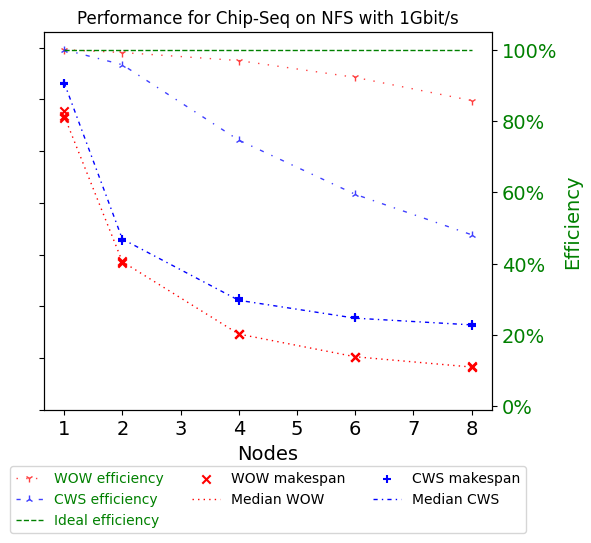

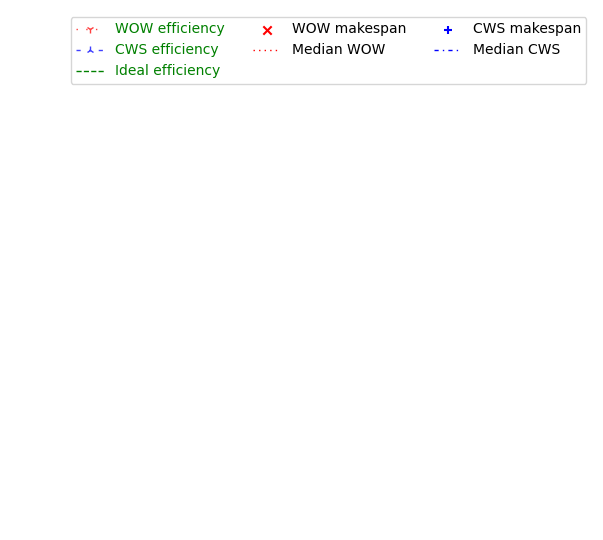

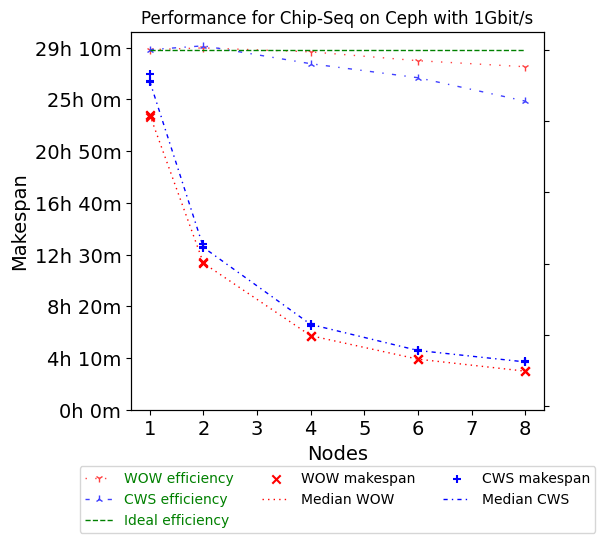

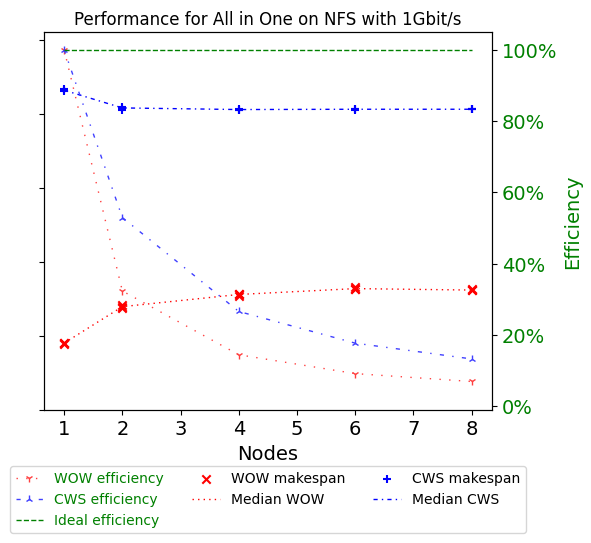

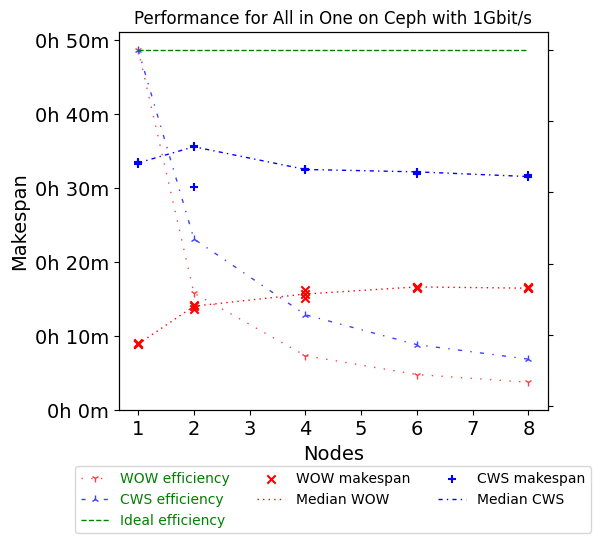

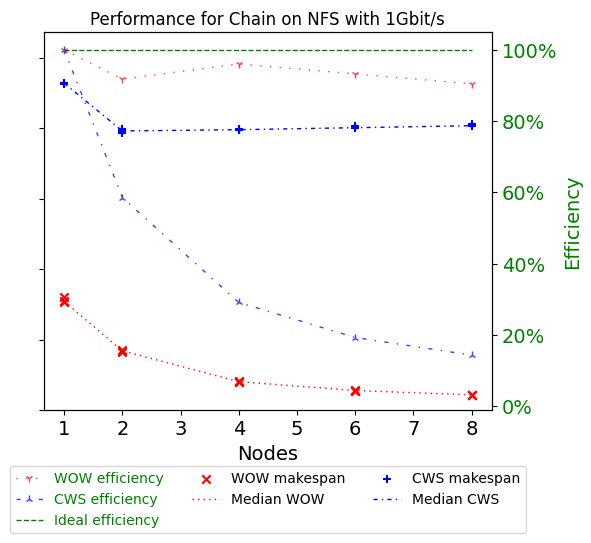

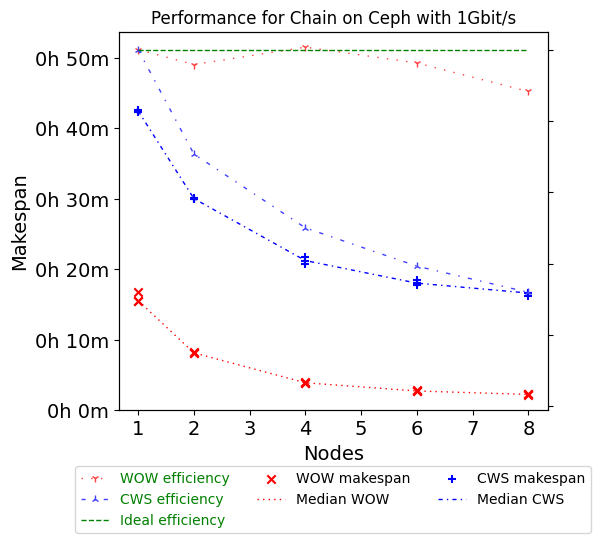

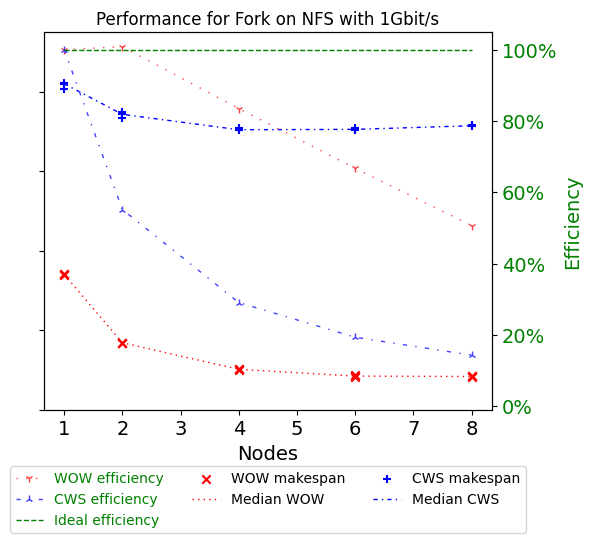

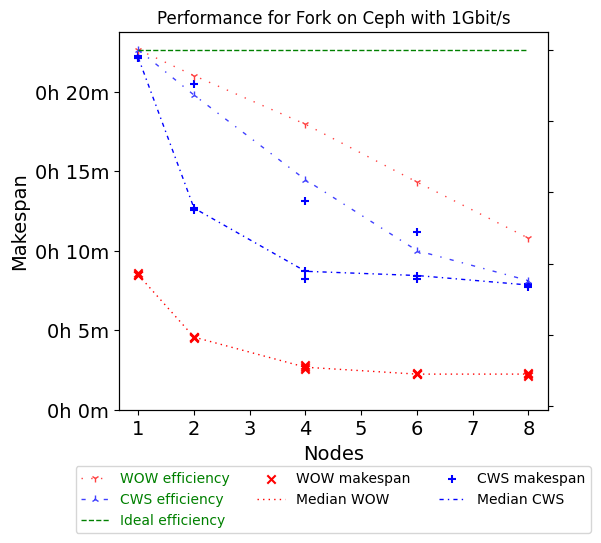

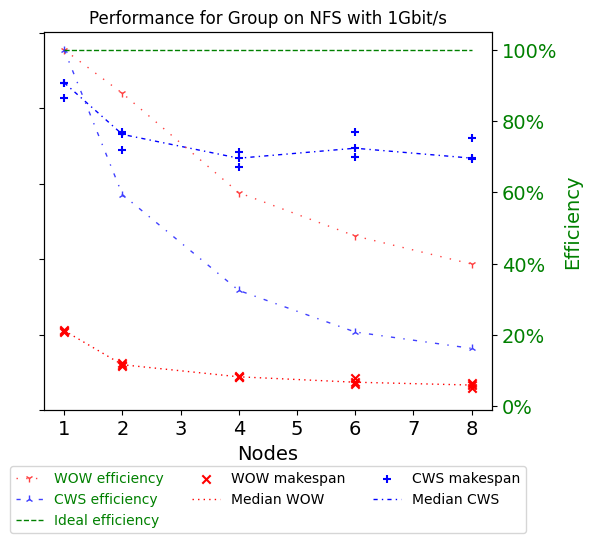

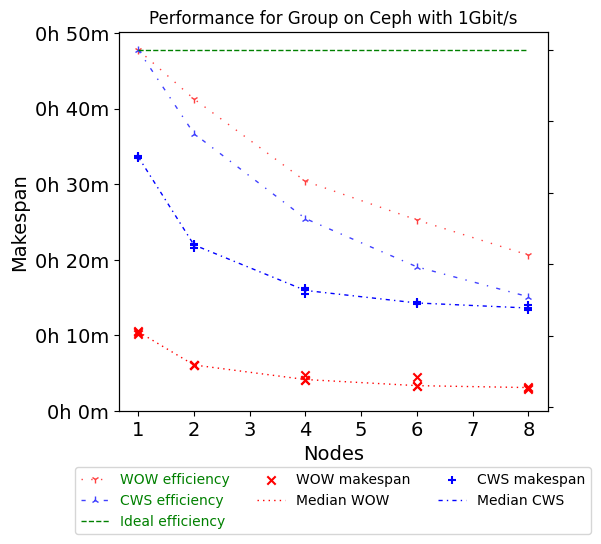

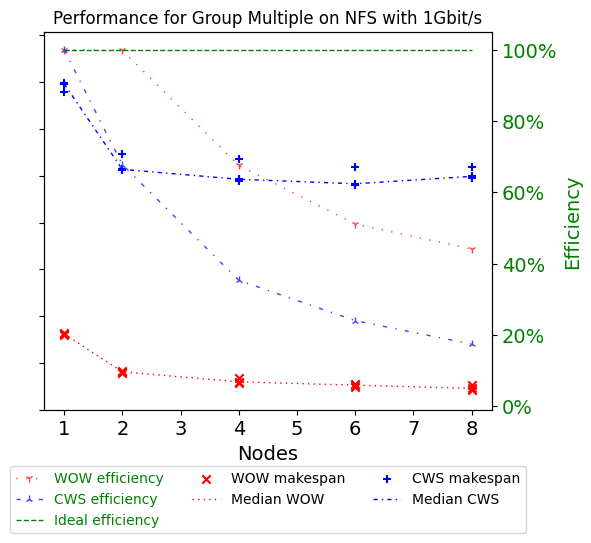

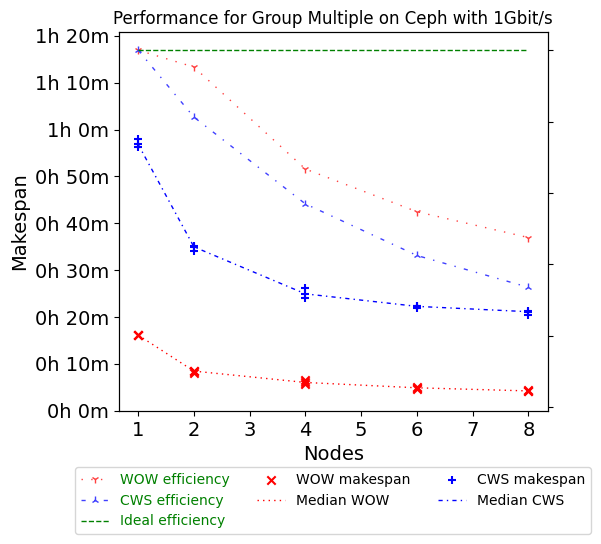

In [17]:
print( "Runtime depending on the " )


# Set the default figure size globally
mpl.rcParams['figure.figsize'] = (6.4, 5.5)
mpl.rcParams['font.size'] = 16

def plotData( results, title, color, ax, linestyle = '-', marker = 'x' ): 
    keys = []
    values = []
    keysMedian = []
    median = []
    ideal = []

    # simulate missing data
    if ( len(results[1]) == 0 ):
        if len(results[2]) > 0:
            results[1] = [np.median(results[2]) * 2]
        elif len(results[4]) > 0:
            results[1] = [np.median(results[4]) * 4]
            results[2] = [np.median(results[4]) * 2]

    valueOnOneNodeLA = np.median(results[1])

    for k, v in results.items():
        if ( len(v) > 0 ):
            keys += ([k] * len(v))
            values += v
            keysMedian.append(k)
            median.append(np.median(v))
            ideal.append( valueOnOneNodeLA / k )

    efficiency = np.array(ideal) / np.array(median)

    ax.scatter(keys, np.array(values) / 1000 / 60, label=title + " makespan", color=color, marker=marker)
    ax.plot( keysMedian, np.array(median) / 1000 / 60, color=color, linestyle=linestyle, linewidth=1, label='Median ' + title)
    #ax.plot( keysMedian, np.array(ideal) / 1000 / 60, color=color, linestyle='--', linewidth=1, label='Theo. ideal ' + title)

    return keysMedian, efficiency

def printScalabilityAndEfficiencySeperate():
    for workflow in ["chipseq"]: #, "allIntoOne", "chain", "fork", "group", "groupMultiple"]:
        for filesystem in ["ceph", "nfs"]:
            laresults = {}
            cephResults = {}
            for nodes in [1,2,4,6,8]:
                results = getResultsForWorkflow( workflow, filesystem, 1, nodes, ["la", "cws"] )
                laresults[nodes] = results["makespan-la"]
                cephResults[nodes] = results["makespan-cws"]

            keysLA, effLA = plotData( laresults, "WOW", "red", plt )
            keysCeph, effCeph = plotData( cephResults, "CWS", "blue", plt )

            # Adding labels and title
            plt.xlabel('Nodes')
            plt.ylabel('Makespan in minutes')
            plt.title('Makespan for ' + workflowNames[workflow] + " on " + filesystem + " with 1Gbit/s")

            # Adding legend
            plt.legend()

            # Display the plot
            plt.show()

            plt.plot(keysLA, np.array(effLA) * 100, label="WOW", color="red", linestyle='-', linewidth=1, marker='x')
            plt.plot(keysCeph, np.array(effCeph) * 100, label="CWS", color="blue", linestyle='-', linewidth=1, marker='x')
            plt.plot(keysLA, np.ones(len(keysLA)) * 100, label="Ideal", color="green", linestyle='--', linewidth=1)
            plt.xlabel('Nodes')
            #format y axis in percent
            ax = plt.gca()
            ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
            
            plt.ylabel('Efficiency')
            plt.title('Efficiency for ' + workflowNames[workflow] + " on " + filesystem + " with 1Gbit/s")
            plt.legend()
            plt.show()

efficiencyResults = []

def printScalabilityAndEfficiencyTogether():
    generatedLegend = False
    for workflow in ["chipseq", "allIntoOne", "chain", "fork", "group", "groupMultiple"]:
        maxValue = 0
        for filesystem in ["nfs","ceph"]:
            plt.rcParams['font.size'] = 14
            laresults = {}
            cephResults = {}
            for nodes in [1,2,4,6,8]:
                results = getResultsForWorkflow( workflow, filesystem, 1, nodes, ["la", "cws"] )
                laresults[nodes] = results["makespan-la"]
                cephResults[nodes] = results["makespan-cws"]

            fig, ax1 = plt.subplots()

            keysLA, effLA = plotData( laresults, "WOW", "red", ax1, (0, (1, 3)), "x" )
            keysCeph, effCeph = plotData( cephResults, "CWS", "blue", ax1, (0, (3, 3, 1, 3)), "+" )

            
            # Adding labels and title
            ax1.set_xlabel('Nodes')
            if ( filesystem == "ceph" ):
                ax1.set_ylabel('Makespan')
            #ax1.title('Makespan for ' + workflowNames[workflow] + " on " + filesystem + " with 1Gbit/s")
            ax1.tick_params(axis='y', labelcolor="black")

            #nfs is always slower
            if ( filesystem == "nfs" ):
                maxValue = (np.max(cephResults[1]) / 60 / 1000) * 1.1
            if workflow == "allIntoOne":
                ax1.set_ylim( 0, maxValue * 1.07 )
            else:
                ax1.set_ylim( 0, maxValue * 1.05 )
            #ax1.legend(loc=0)

            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

            if ( filesystem == "nfs" ):
                ax2.set_ylabel('Efficiency', color="green")  
            ax2.plot(keysLA, np.array(effLA) * 100, label="WOW efficiency", color="#ff4040", linestyle=(0, (1, 6)), linewidth=1, marker='1')
            ax2.plot(keysCeph, np.array(effCeph) * 100, label="CWS efficiency", color="#4040ff", linestyle=(0, (3, 6, 1, 6)), linewidth=1, marker='2')
            ax2.plot(keysLA, np.ones(len(keysLA)) * 100, label="Ideal efficiency", color="green", linestyle='--', linewidth=1)
            ax2.tick_params(axis='y', labelcolor="green")
            ax2.set_ylim(-1, 105)

            efficiencyResults.append( [workflow, filesystem, "wow"] + list(np.array(effLA) * 100) )
            efficiencyResults.append( [workflow, filesystem, "cws"] + list(np.array(effCeph) * 100) )


            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            legend = ax2.legend(lines2 + lines, labels2 + labels, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)

            def percent_formatter(x, pos):
                if ( filesystem == "nfs" ):
                    return f'{x:.0f}%'
                else:
                    return ""
            
            def minutes_to_hour_minute(minutes, pos):
                if ( filesystem == "nfs" ):
                    return ""
                hours, minutes = divmod(minutes, 60)
                return f'{int(hours)}h {int(minutes)}m'

            ax1.yaxis.set_major_formatter(FuncFormatter(minutes_to_hour_minute))
            ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

            plt.xticks(range(1, 9))
            
            fig.tight_layout()
            name = plotsFolder + "makespan_efficiency_" + workflow + "_" + filesystem
            ax2.get_legend().remove()
            plt.savefig( name + ".pdf", bbox_inches='tight')
            plt.rcParams['font.size'] = original_fontsize
            plt.title('Performance for ' + workflowNames[workflow] + " on " + filesystemNames[filesystem] + " with 1Gbit/s")
            legend = ax2.legend(lines2 + lines, labels2 + labels, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)

            for text in legend.get_texts():
                if text.get_text().endswith(" efficiency"):
                    text.set_color('green')
            fig.tight_layout()
            plt.savefig( name + ".jpg")


            if ( not generatedLegend ):
                # Save only the legend
                fig_legend, ax_legend = plt.subplots()
                ax_legend.axis('off')  # Turn off the axis in the legend figure
                legend = ax_legend.legend(handles=legend.legendHandles, labels=[text.get_text() for text in legend.get_texts()], ncol=3)

                for text in legend.get_texts():
                    if text.get_text().endswith(" efficiency"):
                        text.set_color('green')

                fig_legend.tight_layout()
                fig_legend.savefig( plotsFolder + 'legend_only.pdf', bbox_inches='tight')
                generatedLegend = True
            
            plt.show()

printScalabilityAndEfficiencyTogether()

mpl.rcParams['figure.figsize'] = (6.4, 4.8)
mpl.rcParams['font.size'] = 10

In [18]:
efficiencyResultsDf = pd.DataFrame(efficiencyResults, columns=["Workflow", "Filesystem", "Strategy", "1", "2", "4", "6", "8"])
efficiencyResultsDf.to_csv("evaluation" + os.sep + "efficiency.csv")
efficiencyResultsDf

,Workflow,Filesystem,Strategy,1,2,4,6,8
0,chipseq,nfs,wow,100.0,99.202334,96.947147,92.236921,85.740452
1,chipseq,nfs,cws,100.0,95.782597,74.636450,59.451718,48.110088
2,chipseq,ceph,wow,100.0,100.495993,99.395139,96.911484,95.219938
3,chipseq,ceph,cws,100.0,101.084368,96.062445,92.136464,85.572963
4,allIntoOne,nfs,wow,100.0,32.343925,14.468327,9.179325,6.967892
5,allIntoOne,nfs,cws,100.0,52.929841,26.606887,17.721348,13.290537
6,allIntoOne,ceph,wow,100.0,31.729759,14.197071,8.919281,6.760457
7,allIntoOne,ceph,cws,100.0,46.934488,25.682194,17.293932,13.232049
8,chain,nfs,wow,100.0,91.735153,95.998405,93.215910,90.393218
9,chain,nfs,cws,100.0,58.547018,29.143573,19.291545,14.367982


# Data overhead

C:\Users\Fabian Lehmann\AppData\Local\Temp\ipykernel_11932\4031838925.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])


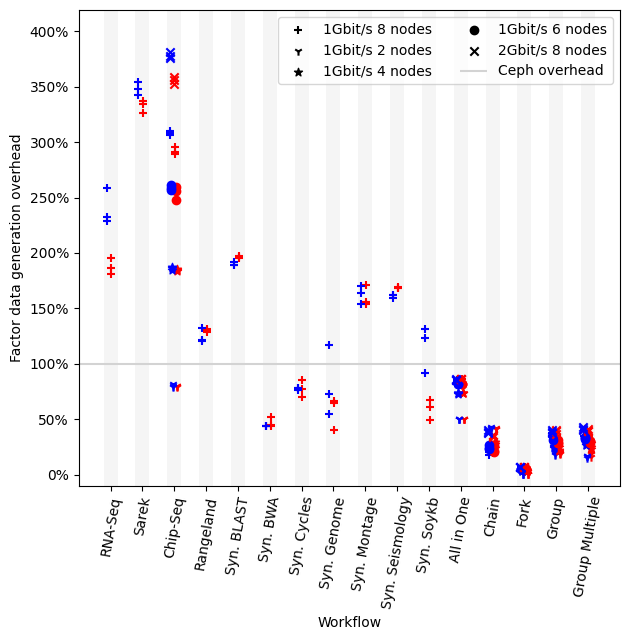

In [19]:
labels = set()

colorMarker = {
    'nfs-2-8' : ("4", "purple"),
    'nfs-1-8' : ("1", "blue"), 
    'nfs-1-6' : ("*", "pink"),
    'nfs-1-4' : ("|", "yellow"),
    'nfs-1-2' : ("2", "green"), 
    'ceph-1-2': ("3", "orange"),
    'ceph-1-4' : ("+", "black"),
    'ceph-1-6' : ("8", "brown"),
    'ceph-1-8' : (".", "red"), 
    'ceph-2-8' : ("x", "coral"),
}


colorMarker = {
    'nfs-2-8' : ("x", "blue"),
    'nfs-1-8' : ("+", "blue"), 
    'nfs-1-6' : ("o", "blue"),
    'nfs-1-4' : ("*", "blue"),
    'nfs-1-2' : ("1", "blue"), 
    'nfs-1-1' : ("p", "blue"), 
    'ceph-2-8' : ("x", "red"),
    'ceph-1-8' : ("+", "red"), 
    'ceph-1-6' : ("o", "red"),
    'ceph-1-4' : ("*", "red"),
    'ceph-1-2': ("1", "red"),
    'ceph-1-1': ("p", "red"),
}

colorMarkerIndex = list(colorMarker.keys())
workflowNamesIndex = list(workflowNames.keys())
avgClusterSpeed = []

sharedData = {}

maxValue = 0

mpl.rcParams['figure.figsize'] = (6.4, 6.5)

for r in resultsRAW:
    if r["nodes"] == 1:
        continue
    if r["strategy"] != "la":
        if ( r["workflow"] not in sharedData ):
            sharedData[r["workflow"]] = []
        sharedData[r["workflow"]].append( r["sharedData"]["workData"] )
for r in resultsRAW:
    if r["nodes"] == 1:
        continue
    if r["strategy"] == "la":
        localData = r["localData"]
        sumLocalData = 0
        for node in localData:
            sumLocalData += localData[node]
        identifier = r["filesystem"] + "-" + str(r["networkspeed"]) + "-" + str(r["nodes"])
        labels.add(identifier)
        label = str(r["networkspeed"]) + "Gbit/s " + str(r["nodes"]) + " nodes"
        factor = (sumLocalData - np.median(sharedData[r["workflow"]])) / (np.median(sharedData[r["workflow"]])) * 100
        avgClusterSpeed.append( {
            "workflow" : r["workflow"],
            "networkspeed" : r["networkspeed"],
            "nodes" : r["nodes"],
            "filesystem" : r["filesystem"],
            "avgTransferSpeed" : (sumLocalData - np.median(sharedData[r["workflow"]])) * 1024 / (r["trace"]["makespan"] / 1000),
            "factor" : factor,
        })
        if ( factor > maxValue ):
            maxValue = factor
        x = workflowNamesIndex.index(r["workflow"]) + (colorMarkerIndex.index(identifier) / len(colorMarker) - 0.5) * 0.3
        plt.scatter( x, factor, label=label, color=colorMarker[identifier][1], marker=colorMarker[identifier][0], zorder= 5)

plt.hlines(100, -1, len(workflowNamesIndex), colors='lightgrey', linestyles='solid', label="Ceph overhead")
plt.xticks(range(len(workflowNamesIndex)), [workflowNames[x] for x in workflowNamesIndex], rotation=80)
plt.xlabel('Workflow')
plt.ylabel('Factor data generation overhead')
plt.xticks(rotation=80)
plt.xlim(-1, len(workflowNamesIndex))
plt.ylim(-10, maxValue * 1.1)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)

ax = plt.gca()
legend_main = ax.legend(loc='upper right')

# Filter out duplicates directly in the legend
handles, labels = [], []
unique_labels = set()

for handle, label in zip(legend_main.legendHandles, legend_main.get_texts()):
    if label.get_text() not in unique_labels:
        if label.get_text() != "Ceph overhead":
            handle.set_color('black')
        handles.append(handle)
        labels.append(label.get_text())
        unique_labels.add(label.get_text())



ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])

for i in workflowNamesIndex:
    plt.vlines(i, -1000, 1000, colors='#f5f5f5', linestyles='solid', linewidth=10, zorder=0 )

# Update the legend in the main plot
legend_main.remove()
ax.legend(handles=handles, labels=labels, loc='upper right', ncol=2)
plt.tight_layout()
plt.savefig( plotsFolder + "data_generation_overhead.pdf", bbox_inches='tight')
plt.show()
mpl.rcParams['figure.figsize'] = (6.4, 4.8)

C:\Users\Fabian Lehmann\AppData\Local\Temp\ipykernel_11932\2918310023.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0f}%'.format(x) for x in ax.get_xticks()])


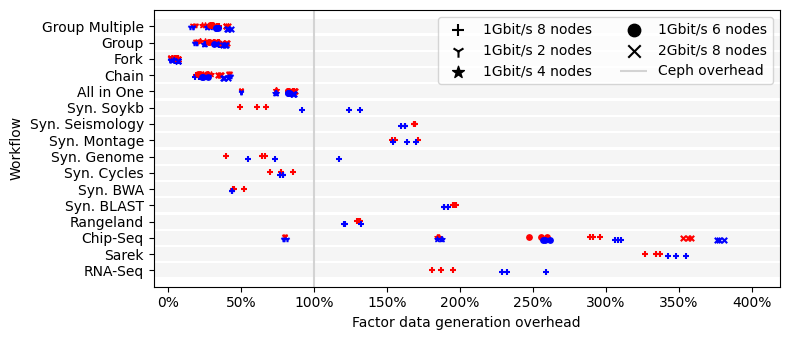

In [20]:
# figure with x-y switch
plt.figure(figsize=(8, 3.5))
labels = set()

avgClusterSpeed = []

sharedData = {}

maxValue = 0

for r in resultsRAW:
    if r["nodes"] == 1:
        continue
    if r["strategy"] != "la":
        if ( r["workflow"] not in sharedData ):
            sharedData[r["workflow"]] = []
        sharedData[r["workflow"]].append( r["sharedData"]["workData"] )
for r in resultsRAW:
    if r["nodes"] == 1:
        continue
    if r["strategy"] == "la":
        localData = r["localData"]
        sumLocalData = 0
        for node in localData:
            sumLocalData += localData[node]
        identifier = r["filesystem"] + "-" + str(r["networkspeed"]) + "-" + str(r["nodes"])
        labels.add(identifier)
        label = str(r["networkspeed"]) + "Gbit/s " + str(r["nodes"]) + " nodes"
        factor = (sumLocalData - np.median(sharedData[r["workflow"]])) / (np.median(sharedData[r["workflow"]])) * 100
        avgClusterSpeed.append( {
            "workflow" : r["workflow"],
            "networkspeed" : r["networkspeed"],
            "nodes" : r["nodes"],
            "filesystem" : r["filesystem"],
            "avgTransferSpeed" : (sumLocalData - np.median(sharedData[r["workflow"]])) * 1024 / (r["trace"]["makespan"] / 1000),
            "factor" : factor,
        })
        if ( factor > maxValue ):
            maxValue = factor
        x = workflowNamesIndex.index(r["workflow"]) + (colorMarkerIndex.index(identifier) / len(colorMarker) - 0.5) * 0.3
        plt.scatter( factor, x, label=label, color=colorMarker[identifier][1], marker=colorMarker[identifier][0], zorder= 5, s=15)

plt.vlines(100, -1, len(workflowNamesIndex), colors='lightgrey', linestyles='solid', label="Ceph overhead")
plt.yticks(range(len(workflowNamesIndex)), [workflowNames[x] for x in workflowNamesIndex])
plt.ylabel('Workflow')
plt.xlabel('Factor data generation overhead')
#plt.xticks(rotation=80)
plt.ylim(-1, len(workflowNamesIndex))
plt.xlim(-10, maxValue * 1.1)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)

ax = plt.gca()
legend_main = ax.legend(loc='upper right')

# Filter out duplicates directly in the legend
handles, labels = [], []
unique_labels = set()

for handle, label in zip(legend_main.legendHandles, legend_main.get_texts()):
    if label.get_text() not in unique_labels:
        if label.get_text() != "Ceph overhead":
            handle.set_color('black')
        handle._sizes = [80]
        handles.append(handle)
        labels.append(label.get_text())
        unique_labels.add(label.get_text())



ax.set_xticklabels(['{:.0f}%'.format(x) for x in ax.get_xticks()])

for i in workflowNamesIndex:
    plt.hlines(i, -1000, 1000, colors='#f5f5f5', linestyles='solid', linewidth=10, zorder=0 )

# Update the legend in the main plot
legend_main.remove()
ax.legend(handles=handles, labels=labels, loc='upper right', ncol=2)
plt.tight_layout()
plt.savefig( plotsFolder + "data_generation_overhead_inverted.pdf", bbox_inches='tight')
plt.show()

In [21]:
avgClusterSpeedDf = pd.DataFrame(avgClusterSpeed)

In [22]:
avgClusterSpeedDf2 = avgClusterSpeedDf[(avgClusterSpeedDf["networkspeed"] == 2) & (avgClusterSpeedDf["nodes"] == 8)].groupby(["workflow", "filesystem"]).median()
avgClusterSpeedDf1 = avgClusterSpeedDf[(avgClusterSpeedDf["networkspeed"] == 1) & (avgClusterSpeedDf["nodes"] == 8)].groupby(["workflow", "filesystem"]).median()

In [23]:
avgClusterSpeedDfMerged = avgClusterSpeedDf2.add_prefix("2Gbit/s ").join(avgClusterSpeedDf1.add_prefix("1Gbit/s "))
avgClusterSpeedDfMerged["speedDiff"] = avgClusterSpeedDfMerged["2Gbit/s avgTransferSpeed"] - avgClusterSpeedDfMerged["1Gbit/s avgTransferSpeed"]
avgClusterSpeedDfMerged["speedDiffRelative"] = (avgClusterSpeedDfMerged["2Gbit/s avgTransferSpeed"] - avgClusterSpeedDfMerged["1Gbit/s avgTransferSpeed"]) / avgClusterSpeedDfMerged["1Gbit/s avgTransferSpeed"] * 100
avgClusterSpeedDfMerged["factorDiff"] = avgClusterSpeedDfMerged["2Gbit/s factor"] - avgClusterSpeedDfMerged["1Gbit/s factor"]
avgClusterSpeedDfMerged["factorDiffRelative"] = (avgClusterSpeedDfMerged["2Gbit/s factor"] - avgClusterSpeedDfMerged["1Gbit/s factor"]) / avgClusterSpeedDfMerged["1Gbit/s factor"] * 100
avgClusterSpeedDfMerged[["1Gbit/s avgTransferSpeed", "2Gbit/s avgTransferSpeed", "1Gbit/s factor", "2Gbit/s factor", "speedDiff", "factorDiff", "speedDiffRelative", "factorDiffRelative"]]

1Gbit/s avgTransferSpeed  2Gbit/s avgTransferSpeed  \
workflow      filesystem                                                       
allIntoOne    ceph                      160.569285                245.173584   
              nfs                       161.572628                241.794431   
chain         ceph                      275.735106                517.641053   
              nfs                       312.086065                561.819301   
chipseq       ceph                      208.139700                255.557500   
              nfs                       199.889483                265.649449   
fork          ceph                       52.243270                 67.294911   
              nfs                        55.984388                 73.162046   
group         ceph                      339.556333                513.788192   
              nfs                       326.694300                556.057393   
groupMultiple ceph                      364.117389                591.035622   
              nfs                       352.987687                632.036826   

                          1Gbit/s factor  2Gbit/s factor   speedDiff  \
workflow      filesystem                                               
allIntoOne    ceph             86.073713       86.406242   84.604300   
              nfs              85.370805       85.590656   80.221803   
chain         ceph             19.704287       35.764553  241.905947   
              nfs              20.878913       38.373216  249.733236   
chipseq       ceph            291.145733      356.123738   47.417799   
              nfs             308.280995      377.530982   65.759966   
fork          ceph              6.929115        6.929111   15.051641   
              nfs               6.929119        6.929115   17.177658   
group         ceph             34.028656       39.502172  174.231859   
              nfs              34.972059       38.741829  229.363093   
groupMultiple ceph             33.787295       39.809405  226.918233   
              nfs              35.169359       41.224674  279.049139   

                          factorDiff  speedDiffRelative  factorDiffRelative  
workflow      filesystem                                                     
allIntoOne    ceph          0.332529          52.690214            0.386331  
              nfs           0.219851          49.650615            0.257524  
chain         ceph         16.060265          87.731283           81.506453  
              nfs          17.494303          80.020630           83.789339  
chipseq       ceph         64.978005          22.781718           22.318034  
              nfs          69.249988          32.898162           22.463269  
fork          ceph         -0.000004          28.810679           -0.000055  
              nfs          -0.000004          30.682943           -0.000055  
group         ceph          5.473516          51.311621           16.085018  
              nfs           3.769771          70.207253           10.779379  
groupMultiple ceph          6.022110          62.320076           17.823593  
              nfs           6.055315          79.053505           17.217587

In [24]:
# count
# task gets copied
# copy is used

In [25]:
data = []
for r in resultsRAW:
    if ( r["strategy"] == "la" and r["nodes"] != 1 ):
        data.append( [r["workflow"], r["nodes"], r["networkspeed"], r["filesystem"], r["copytasks"]["notCopied"], r["copytasks"]["usefulCopied"], r["copytasks"]["uselessCopied"], r["copytasks"]["notCopied"] / r["trace"]['numberPhysicalTasks'] * 100, r["copytasks"]["usefulCopied"] / r["trace"]['numberPhysicalTasks'] * 100] )
        tableToCSV( data, [ "workflow", "nodes", "networkspeed", "filesystem", "notCopied", "usefulCopied", "uselessCopied", "notCopiedPercent", "usefulCopiedPercent" ], "evaluation" + os.sep + "copyOperations.csv" )

# GINI

In [26]:
giniCoefficients = []

def giniForDict( data, nodes ):
    values = []
    for key, value in data.items():
        values.append(float(value))
    if ( len(values) < nodes ):
        values = values + [0] * (nodes - len(values))
    if ( len(values) > nodes ):
        print( "Error: more values than nodes" )
        print( values )
    return gini(np.array(values))

for r in resultsRAW:
    if ( r["strategy"] == "la" and r["nodes"] != 1 ):
        localData = r["localData"]
        tasksByNode = r["trace"]["numberTasksByNode"]
        trace = pd.read_csv( r["folder"] + os.sep + "trace.csv", sep="," )
        trace["allocCpuHours"] = ((trace["realtime"] / 3600000) * trace["cpus"])
        cpuHoursByNode = trace[ ["hostname", "allocCpuHours"] ].groupby("hostname").sum()
        localDataNew = {}
        keys = list(localData.keys())
        keys.sort()
        i = 0
        for k in keys:
            localDataNew[k] = localData[k]
            i += 1
            if ( i == r["nodes"] ):
                break
        giniCoefficients.append( {
            "workflow": r["workflow"],
            "nodes": r["nodes"],
            "networkspeed": r["networkspeed"],
            "filesystem": r["filesystem"],
            "localData": giniForDict( localDataNew, r["nodes"] ),
            "tasksByNode": giniForDict( tasksByNode, r["nodes"] ),
            "cpuHoursByNode": giniForDict( cpuHoursByNode["allocCpuHours"].to_dict(), r["nodes"] )
        } )

In [27]:
pd.DataFrame(giniCoefficients).to_csv( "evaluation" + os.sep + "gini.csv", sep="," )
giniMedian = pd.DataFrame(giniCoefficients).groupby(["workflow","nodes","networkspeed","filesystem"]).median()
giniMedian.to_csv( "evaluation" + os.sep + "giniMedian.csv", sep="," )
giniMedian.reset_index(inplace=True)
giniMedian1 = giniMedian[(giniMedian["nodes"] == 8) & (giniMedian["networkspeed"] == 1)]
giniMedian2 = giniMedian[(giniMedian["nodes"] == 8) & (giniMedian["networkspeed"] == 2)]
#giniMedianMerged = giniMedian1.add_prefix("1Gbit/s ").merge(giniMedian2.add_prefix("2Gbit/s "), on=["workflow", "filesystem"])
#giniMedianMerged
#
giniMedian1.add_prefix("1Gbit/s ").merge(giniMedian2.add_prefix("2Gbit/s "), left_on=["1Gbit/s workflow", "1Gbit/s filesystem"], right_on=["2Gbit/s workflow", "2Gbit/s filesystem"])
giniMedianMerged = giniMedian1.merge(giniMedian2, on=["workflow", "filesystem"], suffixes=("_1Gbit/s", "_2Gbit/s")).drop(["nodes_1Gbit/s", "networkspeed_1Gbit/s", "nodes_2Gbit/s", "networkspeed_2Gbit/s"], axis=1)
giniMedianMerged["diff localData"] = giniMedianMerged["localData_2Gbit/s"] - giniMedianMerged["localData_1Gbit/s"]
giniMedianMerged["diff tasksByNode"] = giniMedianMerged["tasksByNode_2Gbit/s"] - giniMedianMerged["tasksByNode_1Gbit/s"]
giniMedianMerged["diff cpuHoursByNode"] = giniMedianMerged["cpuHoursByNode_2Gbit/s"] - giniMedianMerged["cpuHoursByNode_1Gbit/s"]
giniMedianMerged


,workflow,filesystem,localData_1Gbit/s,tasksByNode_1Gbit/s,cpuHoursByNode_1Gbit/s,localData_2Gbit/s,tasksByNode_2Gbit/s,cpuHoursByNode_2Gbit/s,diff localData,diff tasksByNode,diff cpuHoursByNode
0,allIntoOne,ceph,0.591310,0.038366,0.592982,0.589577,0.035891,0.606856,-0.001732,-0.002475,0.013873
1,allIntoOne,nfs,0.601020,0.080446,0.593897,0.600509,0.080446,0.616739,-0.000511,0.000000,0.022842
2,chain,ceph,0.037383,0.035000,0.042865,0.018599,0.035000,0.030365,-0.018784,0.000000,-0.012501
3,chain,nfs,0.044140,0.066250,0.059409,0.034069,0.057500,0.056219,-0.010070,-0.008750,-0.003190
4,chipseq,ceph,0.006937,0.035659,0.003389,0.008532,0.040465,0.003961,0.001594,0.004806,0.000572
5,chipseq,nfs,0.013422,0.036366,0.005428,0.006636,0.049654,0.004675,-0.006785,0.013288,-0.000753
6,fork,ceph,0.145833,0.164604,0.178444,0.062500,0.075495,0.071335,-0.083333,-0.089109,-0.107109
7,fork,nfs,0.143518,0.162129,0.157458,0.064815,0.077970,0.073191,-0.078704,-0.084158,-0.084267
8,group,ceph,0.084385,0.048507,0.103380,0.064053,0.041045,0.081268,-0.020332,-0.007463,-0.022112
9,group,nfs,0.105822,0.078358,0.100285,0.040014,0.054104,0.053192,-0.065808,-0.024254,-0.047093


In [28]:
print("highest difference in localData:", giniMedianMerged["diff localData"].abs().max())
print("highest difference in tasksByNode:", giniMedianMerged["diff tasksByNode"].abs().max())
print("highest difference in cpuHoursByNode:", giniMedianMerged["diff cpuHoursByNode"].abs().max())



highest difference in localData: 0.08333310228362778
highest difference in tasksByNode: 0.08910891082050777
highest difference in cpuHoursByNode: 0.10710888464839187


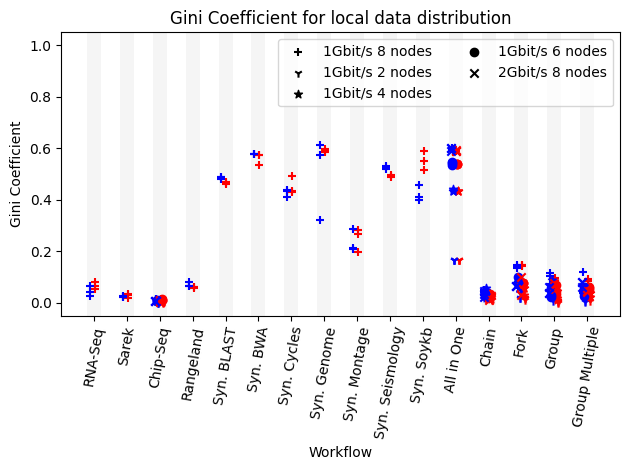

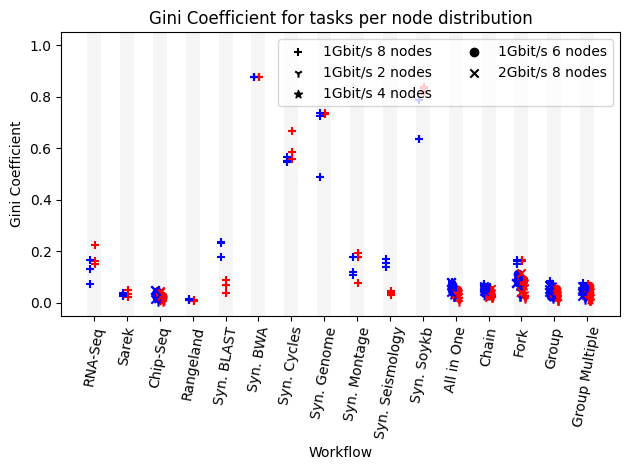

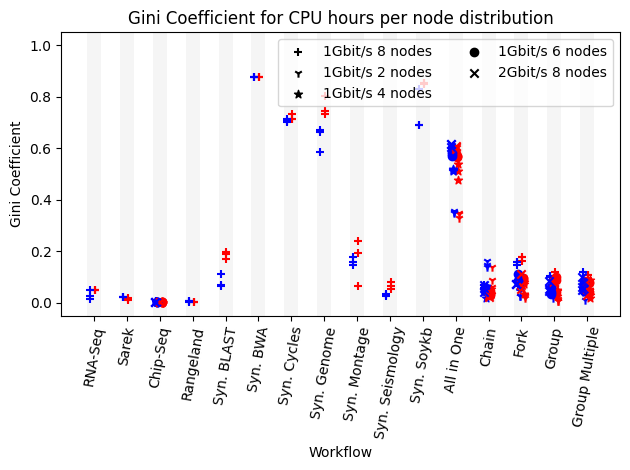

Average data transfer in the cluster in MB/s


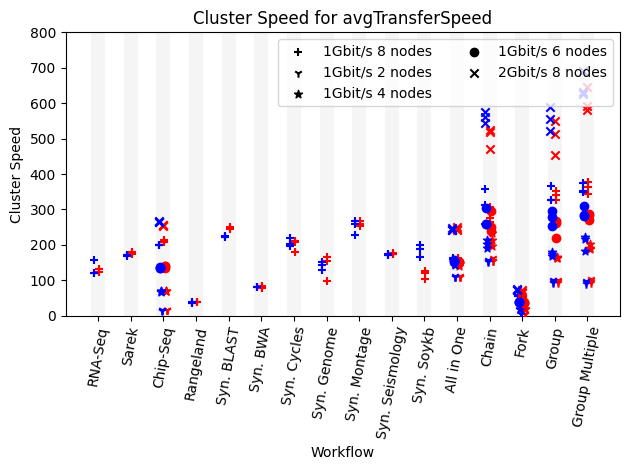

In [29]:
def plotDistribution( data, keyValue, metric, title, minimum, maximum ):
    maxValue = 0

    for g in data:
        identifier = g["filesystem"] + "-" + str(g["networkspeed"]) + "-" + str(g["nodes"])
        factor = g[keyValue]
        label = str(g["networkspeed"]) + "Gbit/s " + str(g["nodes"]) + " nodes"
        if ( factor > maxValue ):
            maxValue = factor
        x = workflowNamesIndex.index(g["workflow"]) + (colorMarkerIndex.index(identifier) / len(colorMarker) - 0.5) * 0.3
        plt.scatter( x, factor, label=label, color=colorMarker[identifier][1], marker=colorMarker[identifier][0], zorder= 5)

    plt.xticks(range(len(workflowNamesIndex)), [workflowNames[x] for x in workflowNamesIndex], rotation=80)
    plt.xlabel('Workflow')
    plt.ylabel( metric )
    plt.xticks(rotation=80)
    plt.xlim(-1, len(workflowNamesIndex))
    plt.ylim(minimum, maximum)
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)

    ax = plt.gca()
    legend_main = ax.legend(loc='upper right')

    # Filter out duplicates directly in the legend
    handles, labels = [], []
    unique_labels = set()

    for handle, label in zip(legend_main.legendHandles, legend_main.get_texts()):
        if label.get_text() not in unique_labels:
            handle.set_color('black')
            handles.append(handle)
            labels.append(label.get_text())
            unique_labels.add(label.get_text())



    #ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])

    for i in workflowNamesIndex:
        plt.vlines(i, -1000, 1000, colors='#f5f5f5', linestyles='solid', linewidth=10, zorder=0 )

    # Update the legend in the main plot
    legend_main.remove()
    ax.legend(handles=handles, labels=labels, loc='upper right', ncol=2)
    plt.title( metric + ' for ' + title)
    plt.tight_layout()
    plt.savefig( plotsFolder + metric.replace(" ", "_") + "_" + keyValue + ".pdf", bbox_inches='tight')
    plt.show()

plotDistribution( giniCoefficients, "localData", "Gini Coefficient", "local data distribution", -0.05, 1.05 )
plotDistribution( giniCoefficients, "tasksByNode", "Gini Coefficient", "tasks per node distribution", -0.05, 1.05 )
plotDistribution( giniCoefficients, "cpuHoursByNode", "Gini Coefficient", "CPU hours per node distribution", -0.05, 1.05 )
print( "Average data transfer in the cluster in MB/s" )
plotDistribution( avgClusterSpeed, "avgTransferSpeed", "Cluster Speed", "avgTransferSpeed", 0, 800 )

In [30]:
avgClusterSpeedDataframe = pd.DataFrame.from_dict( avgClusterSpeed ).groupby(["workflow","nodes","networkspeed","filesystem",]).median()
avgClusterSpeedDataframe.to_csv( "evaluation" + os.sep + "avgClusterSpeed.csv", sep="," )
avgClusterSpeedDataframe = avgClusterSpeedDataframe.reset_index()

In [31]:
avgClusterSpeedDataframe[(avgClusterSpeedDataframe["nodes"] == 8) & (avgClusterSpeedDataframe["networkspeed"] == 1)].sort_values("avgTransferSpeed", ascending=False)

,workflow,nodes,networkspeed,filesystem,avgTransferSpeed,factor
70,groupMultiple,8,1,ceph,364.117389,33.787295
71,groupMultiple,8,1,nfs,352.987687,35.169359
60,group,8,1,ceph,339.556333,34.028656
61,group,8,1,nfs,326.694300,34.972059
31,chain,8,1,nfs,312.086065,20.878913
30,chain,8,1,ceph,275.735106,19.704287
8,Synthetic_Montage_200,8,1,ceph,259.895056,155.651110
9,Synthetic_Montage_200,8,1,nfs,257.627820,163.879993
0,Synthetic_Blast_200,8,1,ceph,246.430836,196.053254
1,Synthetic_Blast_200,8,1,nfs,223.009476,188.857560


# COPs

In [32]:
def countWhichCopyWasUsed ( tasksOnNode, copytasks, notCopied ):
    copies = { 0 : notCopied, "useless" : 0 }
    if ( len(copytasks) != 0 ):
        df = copytasks.merge(tasksOnNode.rename(columns={'hostname': 'used_node', 'name':'task'}), how='left', left_on=['task'], right_on=['task'])
        for name, group_df in df.groupby('task'):
            group_df = group_df.sort_values(by=['starttime']).reset_index()
            result = group_df[ group_df['node'] == group_df['used_node'] ]
            if ( len(result) > 0 ):
                index = result.index[0] + 1 # counting starts with zero
                if ( index not in copies ):
                    copies[index] = 1
                else:
                    copies[index] += 1
            else:
                copies["useless"] += len(group_df)

    #confirm
    if sum(copies.values()) - copies["useless"] != len(tasksOnNode):
        print( "Error: not all copies were counted" )
        print( sum(copies.values()) )
        print( len(tasksOnNode) )
        print( copies )
        return None
    return copies

In [33]:
copies = []
copytasks = None
tasksOnNode = None

for r in resultsRAW:
    if r["strategy"] != "la" or r["nodes"] == 1 or r["workflow"] in ["sarek", "rangeland"]:
        continue

    copytasks = r["copytasks"]["copytasks"]
    tasksOnNode = r["trace"]['task-node'] 

    result = countWhichCopyWasUsed ( tasksOnNode, copytasks, r["copytasks"]["notCopied"] )
    
    if result is None:
        print ( r["workflow"] + " " + r["filesystem"] + " " + str(r["nodes"]) + " " + str(r["networkspeed"]) )
        break
    result["workflow"] = r["workflow"]
    result["filesystem"] = r["filesystem"]
    result["nodes"] = r["nodes"]
    result["networkspeed"] = r["networkspeed"]
    result["#tasks"] = len(tasksOnNode)
    
    copies.append( result )

In [34]:
copiesDf = pd.DataFrame(copies).fillna(0)
allColumns = ["useless",1,2,3,4,5,6,7,8]
copiesDf["#COPs"] = copiesDf[allColumns].sum(axis=1)

In [35]:
copiesDfGrouped = copiesDf.groupby(["filesystem", "nodes", "networkspeed"]).sum()

for i in allColumns:
    copiesDfGrouped[str(i) + " relative #COPs" ] = copiesDfGrouped[i] / copiesDfGrouped["#COPs"] * 100

for i in allColumns:
    copiesDfGrouped[str(i) + " relative #tasks" ] = copiesDfGrouped[i] / copiesDfGrouped["#tasks"] * 100

for i in range(1,8):
    copiesDfGrouped[ ">=" + str(i) ] = copiesDfGrouped[list(range(i,9))].sum(axis=1) / copiesDfGrouped["#COPs"] * 100
    
copiesDfGrouped

C:\Users\Fabian Lehmann\AppData\Local\Temp\ipykernel_11932\3676337447.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  copiesDfGrouped = copiesDf.groupby(["filesystem", "nodes", "networkspeed"]).sum()


0  useless       1  #tasks      2      4  \
filesystem nodes networkspeed                                                   
ceph       2     1             10475.0     2741  2220.0   12699    4.0    0.0   
           4     1             10331.0     2864  1289.0   12699  625.0   12.0   
           6     1             10225.0     2450  1223.0   12699  435.0  272.0   
           8     1             17485.0     3222  1761.0   20658  480.0  214.0   
                 2              9891.0     3195  1336.0   12699  437.0  244.0   
nfs        2     1             10423.0     2733  2271.0   12699    5.0    0.0   
           4     1             10311.0     2982  1328.0   12699  587.0    9.0   
           6     1             10211.0     2590  1268.0   12699  430.0  265.0   
           8     1             17320.0     3401  1875.0   20658  491.0  206.0   
                 2              9733.0     3322  1422.0   12699  444.0  250.0   

                                   7      3      6      5  ...  \
filesystem nodes networkspeed                              ...   
ceph       2     1               0.0    0.0    0.0    0.0  ...   
           4     1               0.0  442.0    0.0    0.0  ...   
           6     1               0.0  298.0   14.0  232.0  ...   
           8     1             142.0  224.0  169.0  172.0  ...   
                 2             152.0  274.0  164.0  191.0  ...   
nfs        2     1               0.0    0.0    0.0    0.0  ...   
           4     1               0.0  464.0    0.0    0.0  ...   
           6     1               0.0  278.0    8.0  239.0  ...   
           8     1             148.0  257.0  168.0  188.0  ...   
                 2             171.0  261.0  193.0  221.0  ...   

                               6 relative #tasks  7 relative #tasks  \
filesystem nodes networkspeed                                         
ceph       2     1                      0.000000           0.000000   
           4     1                      0.000000           0.000000   
           6     1                      0.110245           0.000000   
           8     1                      0.818085           0.687385   
                 2                      1.291440           1.196945   
nfs        2     1                      0.000000           0.000000   
           4     1                      0.000000           0.000000   
           6     1                      0.062997           0.000000   
           8     1                      0.813244           0.716429   
                 2                      1.519805           1.346563   

                               8 relative #tasks        >=1        >=2  \
filesystem nodes networkspeed                                            
ceph       2     1                      0.000000  44.793555   0.080564   
           4     1                      0.000000  45.259939  20.623089   
           6     1                      0.000000  50.243704  25.406174   
           8     1                      0.053248  49.616888  22.079750   
                 2                      0.078746  46.776612  24.521073   
nfs        2     1                      0.000000  45.438211   0.099820   
           4     1                      0.000000  44.469274  19.739292   
           6     1                      0.000000  48.995668  24.025207   
           8     1                      0.024204  49.532572  21.709452   
                 2                      0.031499  47.169211  24.554707   

                                     >=3        >=4       >=5       >=6  \
filesystem nodes networkspeed                                             
ceph       2     1              0.000000   0.000000  0.000000  0.000000   
           4     1              8.677370   0.229358  0.000000  0.000000   
           6     1             16.571893  10.519903  4.995938  0.284322   
           8     1             14.573886  11.071149  7.724785  5.035184   
                 2             17.241379  12.676995  8.612360  5.430618   
nfs 

In [36]:
copiesDfGrouped[[x for x in list(copiesDfGrouped.columns) if " relative #COPs" in str(x)]]

useless relative #COPs  1 relative #COPs  \
filesystem nodes networkspeed                                             
ceph       2     1                          55.206445         44.712991   
           4     1                          54.740061         24.636850   
           6     1                          49.756296         24.837530   
           8     1                          50.383112         27.537138   
                 2                          53.223388         22.255539   
nfs        2     1                          54.561789         45.338391   
           4     1                          55.530726         24.729981   
           6     1                          51.004332         24.970461   
           8     1                          50.467428         27.823119   
                 2                          52.830789         22.614504   

                               2 relative #COPs  3 relative #COPs  \
filesystem nodes networkspeed                                       
ceph       2     1                     0.080564          0.000000   
           4     1                    11.945719          8.448012   
           6     1                     8.834281          6.051990   
           8     1                     7.505864          3.502737   
                 2                     7.279693          4.564384   
nfs        2     1                     0.099820          0.000000   
           4     1                    10.931099          8.640596   
           6     1                     8.467901          5.474596   
           8     1                     7.285947          3.813622   
                 2                     7.061069          4.150763   

                               4 relative #COPs  5 relative #COPs  \
filesystem nodes networkspeed                                       
ceph       2     1                     0.000000          0.000000   
           4     1                     0.229358          0.000000   
           6     1                     5.523964          4.711617   
           8     1                     3.346364          2.689601   
                 2                     4.064634          3.181742   
nfs        2     1                     0.000000          0.000000   
           4     1                     0.167598          0.000000   
           6     1                     5.218590          4.706577   
           8     1                     3.056833          2.789731   
                 2                     3.975827          3.514631   

                               6 relative #COPs  7 relative #COPs  \
filesystem nodes networkspeed                                       
ceph       2     1                     0.000000          0.000000   
           4     1                     0.000000          0.000000   
           6     1                     0.284322          0.000000   
           8     1                     2.642690          2.220485   
                 2                     2.731967          2.532067   
nfs        2     1                     0.000000          0.000000   
           4     1                     0.000000          0.000000   
           6     1                     0.157542          0.000000   
           8     1                     2.492951          2.196172   
                 2                     3.069338          2.719466   

                               8 relative #COPs  
filesystem nodes networkspeed                    
ceph       2     1                     0.000000  
           4     1                     0.000000  
           6     1                     0.000000  
           8     1                     0.172009  
                 2                     0.166583  
nfs        2     1                     0.000000  
           4     1                     0.000000  
           6     1                     0.000000  
           8     1                     0.074195  
                 2                     0.063613

In [37]:
copiesDfGrouped[[x for x in list(copiesDfGrouped.columns) if " relative #tasks" in str(x)]]

useless relative #tasks  1 relative #tasks  \
filesystem nodes networkspeed                                               
ceph       2     1                           21.584377          17.481691   
           4     1                           22.552957          10.150406   
           6     1                           19.292858           9.630680   
           8     1                           15.596863           8.524543   
                 2                           25.159461          10.520513   
nfs        2     1                           21.521380          17.883298   
           4     1                           23.482164          10.457516   
           6     1                           20.395307           9.985038   
           8     1                           16.463356           9.076387   
                 2                           26.159540          11.197732   

                               2 relative #tasks  3 relative #tasks  \
filesystem nodes networkspeed                                         
ceph       2     1                      0.031499           0.000000   
           4     1                      4.921647           3.480589   
           6     1                      3.425467           2.346641   
           8     1                      2.323555           1.084326   
                 2                      3.441216           2.157650   
nfs        2     1                      0.039373           0.000000   
           4     1                      4.622411           3.653831   
           6     1                      3.386093           2.189149   
           8     1                      2.376803           1.244070   
                 2                      3.496338           2.055280   

                               4 relative #tasks  5 relative #tasks  \
filesystem nodes networkspeed                                         
ceph       2     1                      0.000000           0.000000   
           4     1                      0.094496           0.000000   
           6     1                      2.141901           1.826916   
           8     1                      1.035918           0.832607   
                 2                      1.921411           1.504055   
nfs        2     1                      0.000000           0.000000   
           4     1                      0.070872           0.000000   
           6     1                      2.086778           1.882038   
           8     1                      0.997192           0.910059   
                 2                      1.968659           1.740295   

                               6 relative #tasks  7 relative #tasks  \
filesystem nodes networkspeed                                         
ceph       2     1                      0.000000           0.000000   
           4     1                      0.000000           0.000000   
           6     1                      0.110245           0.000000   
           8     1                      0.818085           0.687385   
                 2                      1.291440           1.196945   
nfs        2     1                      0.000000           0.000000   
           4     1                      0.000000           0.000000   
           6     1                      0.062997           0.000000   
           8     1                      0.813244           0.716429   
                 2                      1.519805           1.346563   

                               8 relative #tasks  
filesystem nodes networkspeed                     
ceph       2     1                      0.000000  
           4     1                      0.000000  
           6     1                      0.000000  
           8     1                      0.053248  
                 2                      0.078746  
nfs        2     1                      0.000000  
           4     1                      0.000000  
           6     1                      0.000000  
           8     1                   

In [38]:
copiesDfGrouped["#COPs"]

filesystem  nodes  networkspeed
ceph        2      1               4965.0
            4      1               5232.0
            6      1               4924.0
            8      1               6395.0
                   2               6003.0
nfs         2      1               5009.0
            4      1               5370.0
            6      1               5078.0
            8      1               6739.0
                   2               6288.0
Name: #COPs, dtype: float64

In [39]:
print("How many tasks where COPs are created needed two or less.")
copiesDfGroupedAllFS = copiesDf.groupby(["nodes", "networkspeed"]).sum()
copiesDfGroupedAllFS[["useless", 1 , 2 ]].sum(axis=1) / copiesDfGroupedAllFS["#COPs"] * 100

How many tasks where COPs are created needed two or less.


C:\Users\Fabian Lehmann\AppData\Local\Temp\ipykernel_11932\3089026383.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  copiesDfGroupedAllFS = copiesDf.groupby(["nodes", "networkspeed"]).sum()


nodes  networkspeed
2      1               100.000000
4      1                91.256367
6      1                83.943211
8      1                85.503274
       2                82.629566
dtype: float64

In [40]:
print("Required more than four COPs")
copiesDfGroupedAllFS[[ 5, 6 , 7, 8 ]].sum(axis=1) / copiesDfGroupedAllFS["#COPs"] * 100

Required more than four COPs


nodes  networkspeed
2      1               0.000000
4      1               0.000000
6      1               4.929014
8      1               7.636668
       2               8.998454
dtype: float64

In [41]:
copiesDfGroupedAllFS = copiesDfGrouped.groupby(["nodes", "networkspeed"])[[str(i) + " relative #tasks" for i in allColumns]].mean() #mean works because because both filesystems have the same number of tasks
copiesDfGroupedAllFS

useless relative #tasks  1 relative #tasks  \
nodes networkspeed                                               
2     1                           21.552878          17.682495   
4     1                           23.017560          10.303961   
6     1                           19.844082           9.807859   
8     1                           16.030109           8.800465   
      2                           25.659501          10.859123   

                    2 relative #tasks  3 relative #tasks  4 relative #tasks  \
nodes networkspeed                                                            
2     1                      0.035436           0.000000           0.000000   
4     1                      4.772029           3.567210           0.082684   
6     1                      3.405780           2.267895           2.114340   
8     1                      2.350179           1.164198           1.016555   
      2                      3.468777           2.106465           1.945035   

                    5 relative #tasks  6 relative #tasks  7 relative #tasks  \
nodes networkspeed                                                            
2     1                      0.000000           0.000000           0.000000   
4     1                      0.000000           0.000000           0.000000   
6     1                      1.854477           0.086621           0.000000   
8     1                      0.871333           0.815665           0.701907   
      2                      1.622175           1.405622           1.271754   

                    8 relative #tasks  
nodes networkspeed                     
2     1                      0.000000  
4     1                      0.000000  
6     1                      0.000000  
8     1                      0.038726  
      2                      0.055122

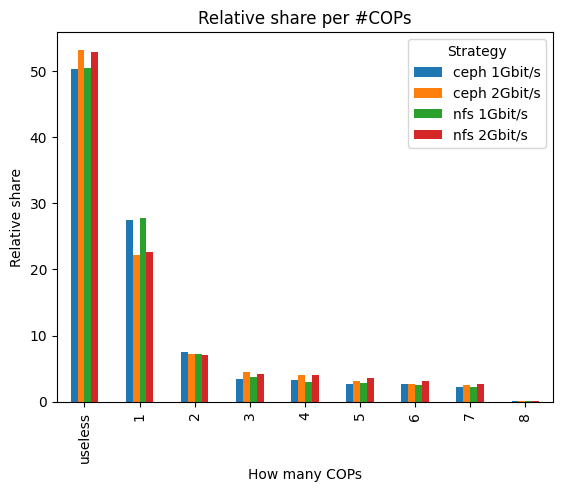

,useless,1,2,3,4,5,6,7,8
Strategy,,,,,,,,,
ceph 1Gbit/s,50.383112,27.537138,7.505864,3.502737,3.346364,2.689601,2.642690,2.220485,0.172009
ceph 2Gbit/s,53.223388,22.255539,7.279693,4.564384,4.064634,3.181742,2.731967,2.532067,0.166583
nfs 1Gbit/s,50.467428,27.823119,7.285947,3.813622,3.056833,2.789731,2.492951,2.196172,0.074195
nfs 2Gbit/s,52.830789,22.614504,7.061069,4.150763,3.975827,3.514631,3.069338,2.719466,0.063613


In [42]:
def plotRelative( df, title ):
    copiesDfGrouped8NodesFiltered = df.reset_index()[df.reset_index()["nodes"] == 8]
    copiesDfGrouped8Nodes = pd.DataFrame({
        'Strategy': copiesDfGrouped8NodesFiltered["filesystem"] + " " + copiesDfGrouped8NodesFiltered["networkspeed"].astype(str) + "Gbit/s",
        })
    for i in allColumns:
        copiesDfGrouped8Nodes[ i ] = copiesDfGrouped8NodesFiltered[str(i) + " relative " + title ]
    copiesDfGrouped8Nodes.set_index('Strategy', inplace=True)
    copiesDfGrouped8Nodes_transposed = copiesDfGrouped8Nodes.T
    copiesDfGrouped8Nodes_transposed.plot(kind='bar')
    plt.xlabel('How many COPs')
    plt.ylabel('Relative share')
    plt.title('Relative share per ' + title )

    plt.show()
    return copiesDfGrouped8Nodes

plotRelative( copiesDfGrouped, "#COPs" )

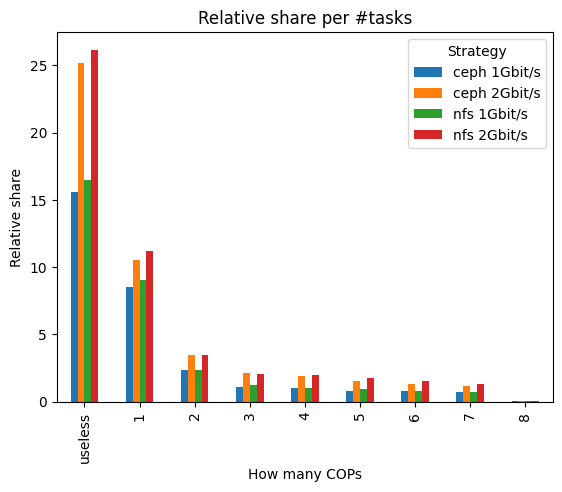

,useless,1,2,3,4,5,6,7,8
Strategy,,,,,,,,,
ceph 1Gbit/s,15.596863,8.524543,2.323555,1.084326,1.035918,0.832607,0.818085,0.687385,0.053248
ceph 2Gbit/s,25.159461,10.520513,3.441216,2.157650,1.921411,1.504055,1.291440,1.196945,0.078746
nfs 1Gbit/s,16.463356,9.076387,2.376803,1.244070,0.997192,0.910059,0.813244,0.716429,0.024204
nfs 2Gbit/s,26.159540,11.197732,3.496338,2.055280,1.968659,1.740295,1.519805,1.346563,0.031499


In [43]:

plotRelative( copiesDfGrouped, "#tasks" )